<a href="https://colab.research.google.com/github/A01793469/CO2MassBalance_Equipo6/blob/main/Avance4_Equipo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

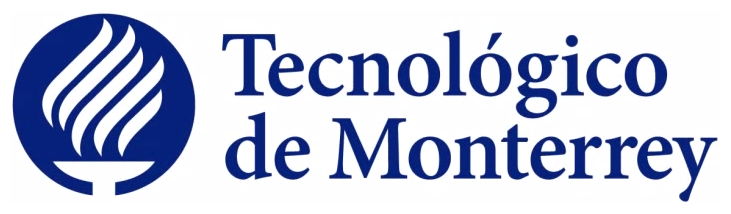

# PROYECTO INTEGRADOR: CO2 Mass Balance

# Avance 4. Modelos alternativos

# PRESENTADO POR:

## Miguel Ángel Aguilera Rodríguez - A00642541

## Carlos Jesús Peñaloza Julio - A01793931

## Alberto Patraca Sotomayor - A01793469

# PROFESORA:

##Dra. Grettel Barceló Alonso

##Dra. Eduviges Ludivina Facundo Flores

# **Avance 1. Análisis exploratorio de datos**

**2.1 Elegir las características más relevantes para reducir la dimensionalidad y aumentar la capacidad de generalización del modelo.**

In [1]:
# Lo primero que realizamos es importar las librerías requeridas
import os # Nos ayuda al manejo de archivos y rutas de archivos
import json  # Es de gran utilizad para manejar archivos .json
import datetime # Manejo de fechas y horas
import warnings

import numpy as np # Funcional para el manejo de matrices de datos
import pandas as pd # Muy útil para el manejo de dataframes

from google.colab import drive # Se utiliza para conectarse con drive y leer los archivos del mismo

# Importar la librería seaborn para graficar la matriz de correlación
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_columns', 3000) # Cambiamos la cantidad de columnas máximas que se muestran
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/content/drive') # Montamos el drive, para poder acceder al archivo del dataset

Mounted at /content/drive


In [4]:
# Definimos el folder donde se encuentran los datos y leemos el json con las
# capacidades de los tanques

data_folder = '/content/drive/MyDrive/PI - CO2 Mass Balance/data'
tank_capacity_json = 'CO2_UT_VOL_202409271421.json'

tank_capacity_path = os.path.join(data_folder, tank_capacity_json)

with open(tank_capacity_path, 'r') as json_file:
    tanks_capacities_dict = json.load(json_file)

tanks_capacities_dict

{'13': 6800,
 '14': 6800,
 '15': 6800,
 '16': 6800,
 '17': 6800,
 '18': 6800,
 '19': 6800,
 '20': 6800,
 '21': 6800,
 '22': 6800,
 '23': 2200,
 '24': 2200,
 '25': 2200,
 '26': 2200,
 '27': 6800,
 '28': 6800,
 '29': 6800,
 '30': 6800,
 '31': 6800,
 '32': 6800,
 '33': 6800,
 '34': 6800,
 '35': 6800,
 '36': 6800,
 '37': 2100,
 '38': 2100,
 '39': 2100,
 '40': 2100,
 '41': 4100,
 '42': 8600,
 '43': 8600,
 '44': 8600,
 '45': 8600,
 '46': 8600,
 '47': 8600,
 '48': 8600,
 '49': 8600,
 '50': 4100}

El diccionario es información sencilla de observar, ya que son pocos valores y con relación 1 a 1, por lo que el análisis es sencillo, notamos que no hay valores erróneos (atípicos, nulos, o en formato incorrecto)

In [5]:
# Leemos el dataset de los registros de los tanques, con las fechas e informaación.

registers_name = 'CO2_Connection_202409271420.csv'
registers_path = os.path.join(data_folder, registers_name)

registers_df = pd.read_csv(registers_path)

registers_df.head()

,UT,Brand,FillingStart,FillingEnd,ConnStart,ConnEnd
0,13,Amstel Utra,2022-04-12 11:43:00,2022-04-12 22:05:00,2022-04-13 13:00:00,2022-04-17 11:00:00
1,13,Carta Blanca,2022-01-17 15:49:00,2022-01-18 00:59:00,2022-01-18 19:00:00,2022-01-22 09:00:00
2,13,Carta Blanca,2022-03-21 06:21:00,2022-03-21 15:47:00,2022-03-22 17:00:00,2022-03-26 02:34:00
3,13,Carta Blanca,2022-04-22 04:32:00,NaN,2022-04-23 05:12:00,2022-04-28 06:00:00
4,13,Carta Blanca,2022-05-27 07:50:00,2022-05-27 16:05:00,2022-05-28 07:00:00,2022-06-01 05:36:00


Notamos que contamos con 4 columnas referentes a fechas, de las cuales solo nos interesan la de Inicio y Fin de conexión. Los de llenado no son tan relevantes.

In [6]:
registers_df.dtypes

,0
UT,int64
Brand,object
FillingStart,object
FillingEnd,object
ConnStart,object
ConnEnd,object


In [7]:
#Imprimimos el tamaño del dataframe
registers_df.shape

(1246, 6)

Podemos notar que tenemos 2 variables que son categóricas: el UT y Brand (Marca), procedemos a obtener sus cardinalidades.

Respecto al UT, no consideramos corroborar la cardinalidad de dicha información, debido a que posteriormente no lo utilizaremos, convirtiéndolo en la capacidad del tanque, que es lo que realmente nos interesa y donde sí podemos manejar esa información.

In [8]:
registers_df.Brand.unique()

array(['Amstel Utra', 'Carta Blanca', 'Coors Light', 'Miller', 'Sol',
       'Tecate', 'Tecate Light', 'RIZZOS', 'TKT R', 'TTKL', 'Bohemia',
       'TK', 'TKTL 6', 'RIZOS', 'Noche Buena'], dtype=object)

Observamos las 15 opciones, sin embargo, notamos que hay varias que son las mismas pero con diferentes nombres, procedemos a unificarlas.

In [9]:
registers_df.Brand.value_counts()

,count
Brand,
Tecate Light,546
Sol,196
Tecate,150
Carta Blanca,145
Miller,73
Amstel Utra,72
Coors Light,42
Bohemia,10
Noche Buena,4


Realmente en este punto, no es de valor realizar análisis estadísticos en esta base de datos, debido a que la mayor cantidad de datos son fechas, y los otros son básicamente los nombres de los tanques.

In [10]:
# Finalmente, leemos el archivo de los registros de flujo de CO2 en la sección de producción
flow_name = 'Flujo_CO2_Recuperado.csv'
flow_path = os.path.join(data_folder, flow_name)

flow_df = pd.read_csv(flow_path)
flow_df.head(10)

,tag_uuid,measured_at,value,event_day
0,nnmN3z283WMuizp7fnss4H,2022-11-11 19:27:48.947,3065.975586,2022-11-11
1,nnmN3z283WMuizp7fnss4H,2022-11-11 19:28:08.541,3013.935791,2022-11-11
2,nnmN3z283WMuizp7fnss4H,2022-11-11 19:29:09.060,2971.429932,2022-11-11
3,nnmN3z283WMuizp7fnss4H,2022-11-11 19:29:29.410,3016.319336,2022-11-11
4,nnmN3z283WMuizp7fnss4H,2022-09-11 08:55:08.658,2542.399902,2022-09-11
5,nnmN3z283WMuizp7fnss4H,2022-08-09 05:57:50.883,2845.898926,2022-08-09
6,nnmN3z283WMuizp7fnss4H,2022-08-09 05:58:50.343,2804.584961,2022-08-09
7,nnmN3z283WMuizp7fnss4H,2023-01-05 21:27:36.454,2374.363281,2023-01-05
8,nnmN3z283WMuizp7fnss4H,2023-01-05 21:27:59.604,2354.103516,2023-01-05
9,nnmN3z283WMuizp7fnss4H,2022-08-09 05:30:26.478,2484.401611,2022-08-09


In [11]:
flow_df.dtypes

,0
tag_uuid,object
measured_at,object
value,float64
event_day,object


In [12]:
# Imprimimos el tamaño de este dataframe
flow_df.shape

(2781109, 4)

Podemos notar que este dataset es más compacto, en términos de elementos, pero posee mayor cantidad de datos en esa única columna. Sin embargo, al ser un elemento numérico, podemos obtener ciertas estadísticas de este.

Además, esa única columna es de las más importantes, ya que es el objetivo de nuestro proyecto, poder predecir el flujo o generación de CO2.

In [13]:
# Obtenemos algunas estadísticas de la columna de flujo equivalente a value
flow_df.describe()

,value
count,2.781109e+06
mean,2.328132e+03
std,6.365585e+02
min,-3.972500e+02
25%,1.940566e+03
50%,2.372774e+03
75%,2.771613e+03
max,6.553433e+03


Teniendo en cuenta la observación hecha, se seguirá trabajando con los valores de la columna "value" que es la que equivale al flujo en cada unidad de tiempo

Sobre el dataset se harán los siguientes cambios de tal manera que podamos seguir trabajando con la columna objetiva de flujo

In [14]:
# Eliminar la columna 'tag_uuid' y 'event_day	'
flow_df = flow_df.drop(['tag_uuid', 'event_day'], axis=1)

# Cambiar el nombre de la columna 'value' a 'CO2 flow(l)'
flow_df = flow_df.rename(columns={'value': 'CO2 flow(l)'})

# Cambiar el nombre de la columna 'measured_at' a 'datetime'
#flow_df = flow_df.rename(columns={'measured_at': 'datetime'})

flow_df.head()

,measured_at,CO2 flow(l)
0,2022-11-11 19:27:48.947,3065.975586
1,2022-11-11 19:28:08.541,3013.935791
2,2022-11-11 19:29:09.060,2971.429932
3,2022-11-11 19:29:29.410,3016.319336
4,2022-09-11 08:55:08.658,2542.399902


También podemos notar que en este rubro, tenemos una gran dependencia temporal, nuestra producción depende enteramente del tiempo que transcurra, además de factores que ya conocemos como la cantidad de cerveza conectada a la sección de producción, y su tipo.

En resumen, podemos definiar como las características de nuestro interés las siguientes:


*   Capacidad de cada tanque
*   Marca de cerveza
*   Fecha y hora de inicio de conexión de los tanques a la producción de CO2
*   Fecha y hora de fin de conexión de los tanques a la producción de CO2
*   Flujo de CO2 por segundo
*   Número de tanque
*   Fecha y hora del fin de llenado, usado como referencia para la edad



**2.2 Abordar y corregir los problemas identificados en los datos.**

En primera instancia, sabemos que en el diccionario de capacidades, no tenemos ningún dato nulo o erróneo, procederemos con los dataframes.

In [15]:
registers_df.isna().sum()

,0
UT,0
Brand,0
FillingStart,0
FillingEnd,15
ConnStart,26
ConnEnd,60


In [16]:
registers_df.isnull().sum()

,0
UT,0
Brand,0
FillingStart,0
FillingEnd,15
ConnStart,26
ConnEnd,60


Con lo anterior podemos demostrar que poseemos datos nulos y erróneos, que seguramente son los mismos, únicamente que duplicados. Nuestra decisión de cómo manejaros es simplemente quitar los registros con este tipo de datos y observar cuántos registros totales realmente se eliminan (ya que varios pueden encontrarse en los mismos renglones)

In [17]:
registers_df.dropna(inplace=True)
registers_df.shape

(1162, 6)

In [18]:
registers_df.isna().sum()

,0
UT,0
Brand,0
FillingStart,0
FillingEnd,0
ConnStart,0
ConnEnd,0


In [19]:
registers_df.isnull().sum()

,0
UT,0
Brand,0
FillingStart,0
FillingEnd,0
ConnStart,0
ConnEnd,0


Perdimos 84 registros (alrededor de un 6% del dataset original), no consideramos que sea mucha la información perdida, y procedemos de esta manera.

In [20]:
registers_df.Brand.value_counts()

,count
Brand,
Tecate Light,513
Sol,193
Tecate,139
Carta Blanca,131
Miller,67
Amstel Utra,62
Coors Light,39
Bohemia,7
Noche Buena,4


In [21]:
registers_df.replace('TTKL', 'Tecate Light', inplace=True)
registers_df.replace('TKTL 6', 'Tecate Light', inplace=True)
registers_df.replace('TK', 'Tecate', inplace=True)
registers_df.replace('TKT R', 'Tecate', inplace=True)

In [22]:
registers_df.Brand.value_counts()

,count
Brand,
Tecate Light,516
Sol,193
Tecate,141
Carta Blanca,131
Miller,67
Amstel Utra,62
Coors Light,39
Bohemia,7
Noche Buena,4


Luego de la elimianación de datos nulos y de clases repetidas (con diferente nombre) terminamos con una cardinalidad de 10 en las marcas, donde podemos notar claramente que la distribución no es pareja. Hay gran diferencia entre cada escalón de las marcas.

In [23]:
flow_df.isna().sum()

,0
measured_at,0
CO2 flow(l),0


In [24]:
flow_df.isnull().sum()

,0
measured_at,0
CO2 flow(l),0


Comprobamos que tampoco tenemos datos erróneos ni nulos en nuestro dataframe de flujo.

*   En este punto, aún no podemos obtener correlaciones, en cada tabla hay pocos datos numéricos, por lo que por separado no hay ninguna relación que los ubique, aún debemos agrupar los datos.
*   Al ubicarlos en un mismo dataframe donde tengamos todas y únicamente nuestras variables de interés, ahí realizaremos un análisis más exhaustivo en términos de correlación y modificaciones que tengamos que hacer, esto lo realizaremos en la siguiente entrega. En primera instancia consideramos que lógicamente, debe haber una correlación directa fuerte entre la cantidad de cerveza total que se encuentra en los tanques que suministran, y la cantidad de CO2 producida.



# **Avance 2. Ingeniería de características**

**2.3 Crear nuevas características para mejorar el rendimiento de los modelos**

In [45]:
"""
Como primer paso en la agrupación de los datos, crearemos un dataframe
nuevo, que será el que manejaremos para el resto del proyecto, tomaremos los
flujos por segundo y los pasaremos a flujos diarios.
"""
# Creamos una copia del dataset original para poder modificarlo sin problema
temp_flow_df = flow_df.copy()
temp_flow_df['date'] = flow_df['measured_at'].map(lambda x: x[:11])
temp_flow_df

,measured_at,CO2 flow(l),date
0,2022-11-11 19:27:48.947,3065.975586,2022-11-11
1,2022-11-11 19:28:08.541,3013.935791,2022-11-11
2,2022-11-11 19:29:09.060,2971.429932,2022-11-11
3,2022-11-11 19:29:29.410,3016.319336,2022-11-11
4,2022-09-11 08:55:08.658,2542.399902,2022-09-11
...,...,...,...
2781104,2024-09-27 15:50:24.081,1489.687500,2024-09-27
2781105,2024-09-11 20:19:47.862,2117.342500,2024-09-11
2781106,2024-09-11 20:20:11.636,2115.753400,2024-09-11
2781107,2024-09-11 20:20:32.909,2091.124000,2024-09-11


In [46]:
#Creamos el dataframe objetivo
target_df = pd.DataFrame()

target_df['date(yyyy-mm-dd)'] = temp_flow_df.date.unique()
target_df.head(10)

,date(yyyy-mm-dd)
0,2022-11-11
1,2022-09-11
2,2022-08-09
3,2023-01-05
4,2022-10-29
5,2022-10-23
6,2022-09-19
7,2022-12-15
8,2022-10-18
9,2022-11-12


In [47]:
def sum_flow_per_date(date, input_df):
    temp_df = input_df[input_df['date'] == date]
    flow_sum = temp_df['CO2 flow(l)'].sum()
    return flow_sum

In [48]:
target_df['co2_flow(l)'] = target_df['date(yyyy-mm-dd)'].map(lambda x: sum_flow_per_date(x, temp_flow_df))
target_df.head(10)

,date(yyyy-mm-dd),co2_flow(l)
0,2022-11-11,8.657291e+06
1,2022-09-11,6.820917e+06
2,2022-08-09,7.979079e+06
3,2023-01-05,4.897387e+06
4,2022-10-29,7.717158e+06
5,2022-10-23,7.329410e+06
6,2022-09-19,8.533419e+06
7,2022-12-15,4.767682e+06
8,2022-10-18,7.320267e+06
9,2022-11-12,8.782855e+06


Una vez listos los flujos diarios, procedemos a agregar la capacidad de los tanques en el dataframe de los registros, para poder manejar mejor los pasos posteriores.

In [49]:
temp_registers_df = registers_df.copy() # Creamos una copia del dataframe original

# Nos apoyamos del diccionario para extraer las capacidades
temp_registers_df['capacity'] = temp_registers_df.UT.map(
    lambda x: tanks_capacities_dict[str(x)])
temp_registers_df.head(10)

,UT,Brand,FillingStart,FillingEnd,ConnStart,ConnEnd,capacity
0,13,Amstel Utra,2022-04-12 11:43:00,2022-04-12 22:05:00,2022-04-13 13:00:00,2022-04-17 11:00:00,6800
1,13,Carta Blanca,2022-01-17 15:49:00,2022-01-18 00:59:00,2022-01-18 19:00:00,2022-01-22 09:00:00,6800
2,13,Carta Blanca,2022-03-21 06:21:00,2022-03-21 15:47:00,2022-03-22 17:00:00,2022-03-26 02:34:00,6800
4,13,Carta Blanca,2022-05-27 07:50:00,2022-05-27 16:05:00,2022-05-28 07:00:00,2022-06-01 05:36:00,6800
5,13,Carta Blanca,2022-08-20 17:44:00,2022-08-21 02:25:00,2022-08-21 18:35:00,2022-08-26 17:36:00,6800
6,13,Carta Blanca,2022-11-30 01:38:00,2022-11-30 20:37:00,2022-12-01 08:00:00,2022-12-06 18:00:00,6800
7,13,Carta Blanca,2023-05-02 15:17:00,2023-05-02 23:39:00,2023-05-03 22:45:00,2023-05-08 05:00:00,6800
8,13,Coors Light,2022-05-03 20:22:00,2022-05-05 04:01:00,2022-05-05 10:00:00,2022-05-10 03:00:00,6800
9,13,Coors Light,2022-10-02 15:01:00,2022-10-04 03:00:00,2022-10-04 15:00:00,2022-10-09 17:00:00,6800
10,13,Coors Light,2023-01-30 12:27:00,2023-01-31 22:34:00,2023-02-01 11:00:00,2023-02-06 06:00:00,6800


Una vez tenemos esta información, el preprocesamiento se vuelve un poco más complejo, debido a que tenemos que crear una tabla temporal por cada marca existente, de manera que saquemos las capacidades relativas y las edades relativas en cada fecha de interés.

In [50]:
# Creamos las columnas específicas que nos ayudarán a no realizar tanto cálculos
# Separamos las fechas y horas
temp_registers_df.loc[:, ['start_con_date','end_con_date']] = \
    temp_registers_df.loc[:, ['ConnStart', 'ConnEnd']].map(
        lambda x: x[:11]).values

temp_registers_df.head(10)

,UT,Brand,FillingStart,FillingEnd,ConnStart,ConnEnd,capacity,start_con_date,end_con_date
0,13,Amstel Utra,2022-04-12 11:43:00,2022-04-12 22:05:00,2022-04-13 13:00:00,2022-04-17 11:00:00,6800,2022-04-13,2022-04-17
1,13,Carta Blanca,2022-01-17 15:49:00,2022-01-18 00:59:00,2022-01-18 19:00:00,2022-01-22 09:00:00,6800,2022-01-18,2022-01-22
2,13,Carta Blanca,2022-03-21 06:21:00,2022-03-21 15:47:00,2022-03-22 17:00:00,2022-03-26 02:34:00,6800,2022-03-22,2022-03-26
4,13,Carta Blanca,2022-05-27 07:50:00,2022-05-27 16:05:00,2022-05-28 07:00:00,2022-06-01 05:36:00,6800,2022-05-28,2022-06-01
5,13,Carta Blanca,2022-08-20 17:44:00,2022-08-21 02:25:00,2022-08-21 18:35:00,2022-08-26 17:36:00,6800,2022-08-21,2022-08-26
6,13,Carta Blanca,2022-11-30 01:38:00,2022-11-30 20:37:00,2022-12-01 08:00:00,2022-12-06 18:00:00,6800,2022-12-01,2022-12-06
7,13,Carta Blanca,2023-05-02 15:17:00,2023-05-02 23:39:00,2023-05-03 22:45:00,2023-05-08 05:00:00,6800,2023-05-03,2023-05-08
8,13,Coors Light,2022-05-03 20:22:00,2022-05-05 04:01:00,2022-05-05 10:00:00,2022-05-10 03:00:00,6800,2022-05-05,2022-05-10
9,13,Coors Light,2022-10-02 15:01:00,2022-10-04 03:00:00,2022-10-04 15:00:00,2022-10-09 17:00:00,6800,2022-10-04,2022-10-09
10,13,Coors Light,2023-01-30 12:27:00,2023-01-31 22:34:00,2023-02-01 11:00:00,2023-02-06 06:00:00,6800,2023-02-01,2023-02-06


In [51]:
temp_registers_df.loc[:, ['start_con_time','end_con_time']] = \
    temp_registers_df.loc[:, ['ConnStart', 'ConnEnd']].map(
        lambda x: x[-8:-3]).values

temp_registers_df.head(10)

,UT,Brand,FillingStart,FillingEnd,ConnStart,ConnEnd,capacity,start_con_date,end_con_date,start_con_time,end_con_time
0,13,Amstel Utra,2022-04-12 11:43:00,2022-04-12 22:05:00,2022-04-13 13:00:00,2022-04-17 11:00:00,6800,2022-04-13,2022-04-17,13:00,11:00
1,13,Carta Blanca,2022-01-17 15:49:00,2022-01-18 00:59:00,2022-01-18 19:00:00,2022-01-22 09:00:00,6800,2022-01-18,2022-01-22,19:00,09:00
2,13,Carta Blanca,2022-03-21 06:21:00,2022-03-21 15:47:00,2022-03-22 17:00:00,2022-03-26 02:34:00,6800,2022-03-22,2022-03-26,17:00,02:34
4,13,Carta Blanca,2022-05-27 07:50:00,2022-05-27 16:05:00,2022-05-28 07:00:00,2022-06-01 05:36:00,6800,2022-05-28,2022-06-01,07:00,05:36
5,13,Carta Blanca,2022-08-20 17:44:00,2022-08-21 02:25:00,2022-08-21 18:35:00,2022-08-26 17:36:00,6800,2022-08-21,2022-08-26,18:35,17:36
6,13,Carta Blanca,2022-11-30 01:38:00,2022-11-30 20:37:00,2022-12-01 08:00:00,2022-12-06 18:00:00,6800,2022-12-01,2022-12-06,08:00,18:00
7,13,Carta Blanca,2023-05-02 15:17:00,2023-05-02 23:39:00,2023-05-03 22:45:00,2023-05-08 05:00:00,6800,2023-05-03,2023-05-08,22:45,05:00
8,13,Coors Light,2022-05-03 20:22:00,2022-05-05 04:01:00,2022-05-05 10:00:00,2022-05-10 03:00:00,6800,2022-05-05,2022-05-10,10:00,03:00
9,13,Coors Light,2022-10-02 15:01:00,2022-10-04 03:00:00,2022-10-04 15:00:00,2022-10-09 17:00:00,6800,2022-10-04,2022-10-09,15:00,17:00
10,13,Coors Light,2023-01-30 12:27:00,2023-01-31 22:34:00,2023-02-01 11:00:00,2023-02-06 06:00:00,6800,2023-02-01,2023-02-06,11:00,06:00


In [52]:
# Finalmente agregamos la edad inicial de cada uno (en minutos), para ello creamos una función que nos ayude

def find_initial_age(init_df):
    dt_format = '%Y-%m-%d %H:%M:%S'
    end_fill = datetime.datetime.strptime(init_df['FillingEnd'], dt_format)
    start_con = datetime.datetime.strptime(init_df['ConnStart'], dt_format)
    #start_fill = datetime.datetime.strptime(init_df['FillingStart'], dt_format)
    delta = start_con - end_fill
    return int(delta.total_seconds()/60)

temp_registers_df['initial_age'] = temp_registers_df.apply(find_initial_age, axis=1)
temp_registers_df.head(10)

,UT,Brand,FillingStart,FillingEnd,ConnStart,ConnEnd,capacity,start_con_date,end_con_date,start_con_time,end_con_time,initial_age
0,13,Amstel Utra,2022-04-12 11:43:00,2022-04-12 22:05:00,2022-04-13 13:00:00,2022-04-17 11:00:00,6800,2022-04-13,2022-04-17,13:00,11:00,895
1,13,Carta Blanca,2022-01-17 15:49:00,2022-01-18 00:59:00,2022-01-18 19:00:00,2022-01-22 09:00:00,6800,2022-01-18,2022-01-22,19:00,09:00,1081
2,13,Carta Blanca,2022-03-21 06:21:00,2022-03-21 15:47:00,2022-03-22 17:00:00,2022-03-26 02:34:00,6800,2022-03-22,2022-03-26,17:00,02:34,1513
4,13,Carta Blanca,2022-05-27 07:50:00,2022-05-27 16:05:00,2022-05-28 07:00:00,2022-06-01 05:36:00,6800,2022-05-28,2022-06-01,07:00,05:36,895
5,13,Carta Blanca,2022-08-20 17:44:00,2022-08-21 02:25:00,2022-08-21 18:35:00,2022-08-26 17:36:00,6800,2022-08-21,2022-08-26,18:35,17:36,970
6,13,Carta Blanca,2022-11-30 01:38:00,2022-11-30 20:37:00,2022-12-01 08:00:00,2022-12-06 18:00:00,6800,2022-12-01,2022-12-06,08:00,18:00,683
7,13,Carta Blanca,2023-05-02 15:17:00,2023-05-02 23:39:00,2023-05-03 22:45:00,2023-05-08 05:00:00,6800,2023-05-03,2023-05-08,22:45,05:00,1386
8,13,Coors Light,2022-05-03 20:22:00,2022-05-05 04:01:00,2022-05-05 10:00:00,2022-05-10 03:00:00,6800,2022-05-05,2022-05-10,10:00,03:00,359
9,13,Coors Light,2022-10-02 15:01:00,2022-10-04 03:00:00,2022-10-04 15:00:00,2022-10-09 17:00:00,6800,2022-10-04,2022-10-09,15:00,17:00,720
10,13,Coors Light,2023-01-30 12:27:00,2023-01-31 22:34:00,2023-02-01 11:00:00,2023-02-06 06:00:00,6800,2023-02-01,2023-02-06,11:00,06:00,746


In [53]:
# Finalmente, desechamos nuevamente las columnas que no nos funcionan

temp_registers_df.drop(columns=['FillingStart',	'FillingEnd',	'ConnStart',	'ConnEnd'], inplace=True)
temp_registers_df.head(10)

,UT,Brand,capacity,start_con_date,end_con_date,start_con_time,end_con_time,initial_age
0,13,Amstel Utra,6800,2022-04-13,2022-04-17,13:00,11:00,895
1,13,Carta Blanca,6800,2022-01-18,2022-01-22,19:00,09:00,1081
2,13,Carta Blanca,6800,2022-03-22,2022-03-26,17:00,02:34,1513
4,13,Carta Blanca,6800,2022-05-28,2022-06-01,07:00,05:36,895
5,13,Carta Blanca,6800,2022-08-21,2022-08-26,18:35,17:36,970
6,13,Carta Blanca,6800,2022-12-01,2022-12-06,08:00,18:00,683
7,13,Carta Blanca,6800,2023-05-03,2023-05-08,22:45,05:00,1386
8,13,Coors Light,6800,2022-05-05,2022-05-10,10:00,03:00,359
9,13,Coors Light,6800,2022-10-04,2022-10-09,15:00,17:00,720
10,13,Coors Light,6800,2023-02-01,2023-02-06,11:00,06:00,746


En este punto interesa conocer el número de tanques y cuántas veces está cada uno presente en el dataframe.

In [36]:
# Contar los tanques que se manejan (unique y count) y cuantas unidades existen de cada una.

ut_counts = temp_registers_df.UT.value_counts()
print("Unique UTs:", len(ut_counts))
print("Count of each UT:")
print(ut_counts)

Unique UTs: 38
Count of each UT:
UT
29    48
19    47
18    46
20    46
28    46
13    45
15    45
16    45
35    45
36    43
30    43
21    43
17    43
33    42
27    42
22    42
14    41
34    41
32    40
31    39
42    23
41    23
50    23
47    20
38    19
43    19
44    18
49    18
45    17
46    17
40    16
37    15
48    15
23    10
39    10
25    10
24     9
26     8
Name: count, dtype: int64


En total se tienen 38 tanques, de los cuales el 29 es el que tiene mayor participación aunque la diferencia es de una con el 19 y 2 con el 8, 20 y 28. El menor frecuencia es el 26 y 24 con 8 y 9 respectivamente.

Antes de pasar a la unificación de marcas considerando el volumen y age así como la unificación del dataset con flujo y la relación por fechas, se procederá a revisar mediante gráfica de frecuencia la relación entre UT y Brand.

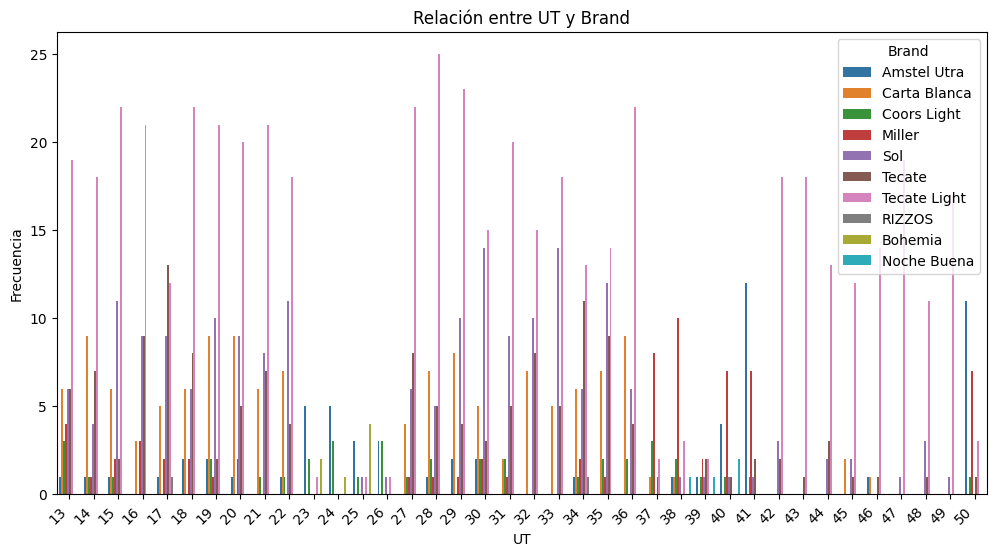

In [37]:
# Gráfica de relación entre UT y Brand
plt.figure(figsize=(12, 6))
sns.countplot(x='UT', hue='Brand', data=registers_df)
plt.title('Relación entre UT y Brand')
plt.xlabel('UT')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Brand')
plt.show()

Se pudo observar que por tanque se puede tener más de una marca de cerveza, especialmente del 13 al 22, del 27 al 38 y con menor frecuencia entre 23 y 26 y del 40 al 50.

Para complementar el análisis se realizará la agrupación por UT y Brand contando ocurrencias e identificando la marca en cada tanque.

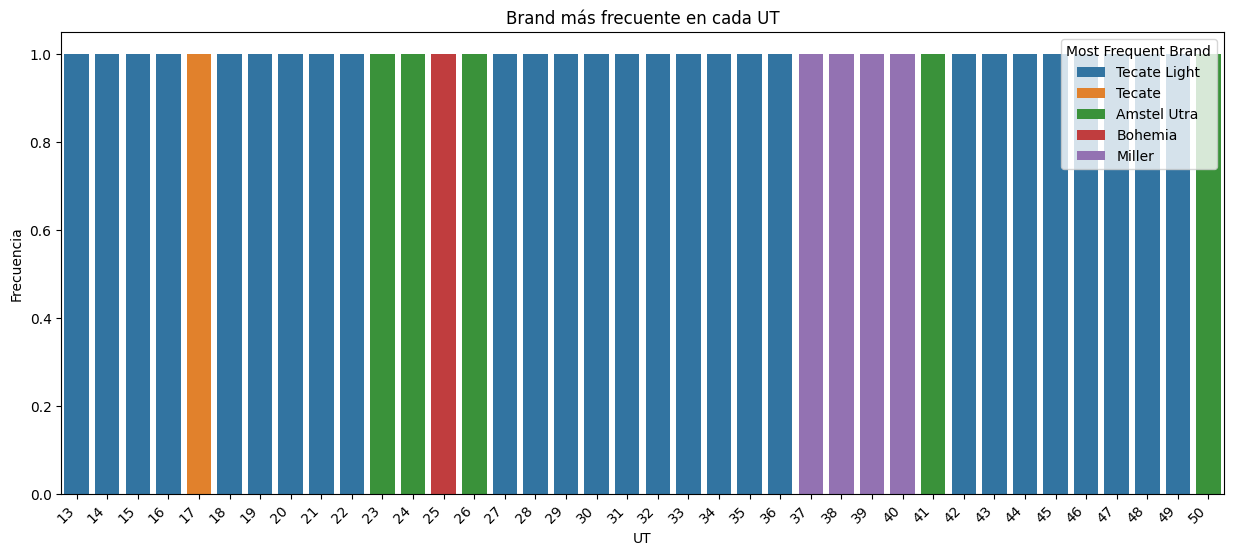

In [ ]:
# Agrupar por UT y Brand, contar las ocurrencias y encontrar la Brand más frecuente en cada UT
brand_counts = temp_registers_df.groupby(['UT', 'Brand'])['Brand'].count().unstack().fillna(0)
most_frequent_brand = brand_counts.idxmax(axis=1)

# Crear un DataFrame con la Brand más frecuente para cada UT
most_frequent_brand_df = pd.DataFrame({'UT': most_frequent_brand.index, 'Most Frequent Brand': most_frequent_brand.values})

# Gráfica de barras para visualizar la Brand más frecuente en cada UT
plt.figure(figsize=(15, 6))
sns.countplot(x='UT', hue='Most Frequent Brand', data=most_frequent_brand_df)
plt.title('Brand más frecuente en cada UT')
plt.xlabel('UT')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Most Frequent Brand')
plt.show()


En la gráfica anterior se puede identificar que la marca de cerveza con mayor presencia en los tanques es Tecate Light en 27 de los 38 tanques, esto se estará revisando a detalle más adelante. Para tener mejor observación se realizará un diagrama de Pareto.

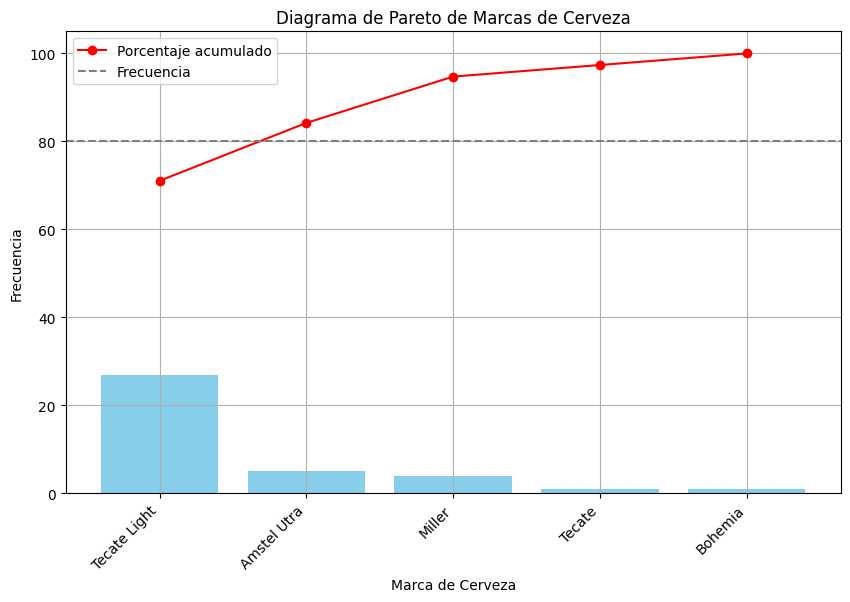

In [ ]:
# Contar la frecuencia de cada marca
brand_counts = most_frequent_brand_df['Most Frequent Brand'].value_counts()

# Calcular el porcentaje acumulado
cumulative_percentage = (brand_counts.cumsum() / brand_counts.sum()) * 100

# Crear un DataFrame con la información necesaria para el diagrama de Pareto
pareto_df = pd.DataFrame({'Brand': brand_counts.index, 'Frequency': brand_counts.values, 'Cumulative Percentage': cumulative_percentage})

# Crear la gráfica de Pareto
plt.figure(figsize=(10, 6))
ax1 = plt.bar(pareto_df['Brand'], pareto_df['Frequency'], color='skyblue')
ax2 = plt.plot(pareto_df['Brand'], pareto_df['Cumulative Percentage'], color='red', marker='o')
plt.xlabel('Marca de Cerveza')
plt.ylabel('Frecuencia')
plt.title('Diagrama de Pareto de Marcas de Cerveza')
plt.xticks(rotation=45, ha='right')

# Agregar una línea de referencia del 80%
plt.axhline(y=80, color='gray', linestyle='--')

# Mostrar la gráfica
plt.legend(['Porcentaje acumulado', 'Frecuencia'])
plt.grid(True)
plt.show()

El diagrama de Pareto anterior representa la relación entre la marca de cerveza y la frecuencia de esta en el flujo y volumen acumulado en los tanques, el 80% de la ocupación está representado por Tecate Light y Amstel Ultra con las cuales se podría enfocar el modelo.

Como complemento se revisará lo que representa cada marca de cerveza con respecto al volumen acumulado en general.

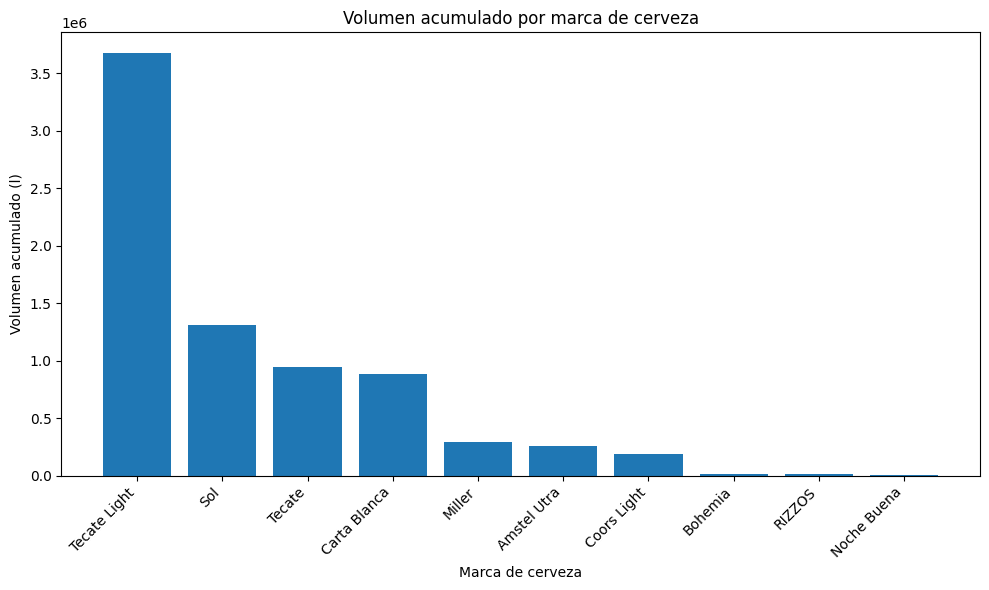

In [ ]:
# Agrupar por marca y sumar la capacidad
brand_capacity = temp_registers_df.groupby('Brand')['capacity'].sum()

# Ordenar los valores de manera descendente
brand_capacity_sorted = brand_capacity.sort_values(ascending=False)

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(brand_capacity_sorted.index, brand_capacity_sorted.values)
plt.xlabel('Marca de cerveza')
plt.ylabel('Volumen acumulado (l)')
plt.title('Volumen acumulado por marca de cerveza')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ajusta el diseño para evitar que las etiquetas se superpongan
plt.show()

La gráfica anterior permite analizar el comportamiento en cuanto a volumen acumulado por marca de cerveza, a diferencia del diagrama de Pareto que muestra la frecuencia de cada marca por tanque, acá se puede tener enfoque en las cuatro primeras que representan aproximadamente el 70% del volumen acumulado.

A continuación se harán modificaciones relacionadas con el ajuste del tiempo de llenado, la comparación de fechas para luego agrupar y expresar las proporciones de volumen y age con lo cual se armará el dataframe que contendrá la fecha en año-mes-día, flujo y volumen y age para cada marca de cerveza.

In [ ]:
def get_day_minutes(init_time):
    t_format = '%H:%M'
    day_time = datetime.datetime.strptime(init_time, t_format)
    minutes = (60*day_time.hour) + day_time.minute
    return minutes

In [ ]:
def compare_dates(date_a, date_b):
    d_format = '%Y-%m-%d'
    date_x = datetime.datetime.strptime(date_a.replace(' ',''), d_format)
    date_y = datetime.datetime.strptime(date_b.replace(' ',''), d_format)
    delta = date_y - date_x
    days = delta.days
    return days

In [ ]:
def calc_date_proportion(init_df, ref_date):
    days_start = compare_dates(ref_date, init_df['start_con_date'])
    days_end = compare_dates(ref_date, init_df['end_con_date'])

    if days_start > 0:
        return 0.0
    elif days_end < 0:
        return 0.0
    elif days_start == 0 and days_end == 0:
        start_min = get_day_minutes(init_df['start_con_time'])
        end_min = get_day_minutes(init_df['end_con_time'])
        return (end_min-start_min)/1440
    elif days_start == 0 and days_end > 0:
        start_min = get_day_minutes(init_df['start_con_time'])
        return (1440-start_min)/1440
    elif days_end == 0 and days_start < 0:
        end_min = get_day_minutes(init_df['end_con_time'])
        return (end_min)/1440
    else:
        return 1.0

In [ ]:
for brand in registers_df.Brand.unique():
    target_df[f'{brand.replace(" ","_")}_prop_volume(l)'] = np.zeros((len(target_df),))
    target_df[f'{brand.replace(" ","_")}_prop_age(minutes)'] = np.zeros((len(target_df),))
    temp_2_df = temp_registers_df.copy()
    for reference_date in target_df['date(yyyy-mm-dd)'].values:
        temp_brand_df = temp_2_df[temp_2_df['Brand'] == brand]
        temp_brand_df['proportion'] = temp_brand_df.apply(
            lambda x: calc_date_proportion(x, reference_date), axis=1)
        temp_brand_df['prop_capacity'] = temp_brand_df.capacity * temp_brand_df.proportion
        temp_brand_df['prop_age'] = 720 * temp_brand_df['proportion'] + temp_brand_df['initial_age']
        temp_brand_df.loc[temp_brand_df.proportion == 0.0, 'prop_age'] = 0.0
        prop_vol, prop_age = temp_brand_df[['prop_capacity', 'prop_age']].sum().values
        target_df.loc[target_df['date(yyyy-mm-dd)'] == reference_date,
                           f'{brand.replace(" ","_")}_prop_volume(l)'] = prop_vol
        target_df.loc[target_df['date(yyyy-mm-dd)'] == reference_date,
                           f'{brand.replace(" ","_")}_prop_age(minutes)'] = prop_age

In [ ]:
target_df.head()

,date(yyyy-mm-dd),co2_flow(l),Amstel_Utra_prop_volume(l),Amstel_Utra_prop_age(minutes),Carta_Blanca_prop_volume(l),Carta_Blanca_prop_age(minutes),Coors_Light_prop_volume(l),Coors_Light_prop_age(minutes),Miller_prop_volume(l),Miller_prop_age(minutes),Sol_prop_volume(l),Sol_prop_age(minutes),Tecate_prop_volume(l),Tecate_prop_age(minutes),Tecate_Light_prop_volume(l),Tecate_Light_prop_age(minutes),RIZZOS_prop_volume(l),RIZZOS_prop_age(minutes),Bohemia_prop_volume(l),Bohemia_prop_age(minutes),Noche_Buena_prop_volume(l),Noche_Buena_prop_age(minutes)
0,2022-11-11,8.657291e+06,5233.333333,3151.0,13600.000000,3414.0,0.000000,0.0,0.000000,0.0,20400.000000,5966.0,13600.000000,4736.0,55675.000000,-30685.0,6800.0,433.0,0.0,0.0,0.0,0.0
1,2022-09-11,6.820917e+06,0.000000,0.0,27105.555556,6917.0,0.000000,0.0,0.000000,0.0,20400.000000,4633.0,6800.000000,2358.0,49802.777778,-75263.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-08-09,7.979079e+06,4100.000000,1377.0,13600.000000,1749.0,8900.000000,1775.0,5383.333333,1191.0,25122.222222,5793.0,13600.000000,2927.0,28100.000000,-81380.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-05,4.897387e+06,1618.750000,2242.0,6800.000000,1332.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,7933.333333,3018.0,33829.166667,8655.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-29,7.717158e+06,0.000000,0.0,7730.277778,3397.5,1906.041667,2539.5,0.000000,0.0,19691.666667,4939.0,12726.388889,5288.5,47277.777778,7220.0,0.0,0.0,0.0,0.0,0.0,0.0


Considerando la información que se tiene relacionada con el flujo por periodo y por marca, se consideró complementar el análisis exploratorio con las gráficas de flujo vs fecha (día, mes y año).

In [ ]:
# Convertir la columna 'date(yyyy-mm-dd)' a formato datetime
target_df['date(yyyy-mm-dd)'] = pd.to_datetime(target_df['date(yyyy-mm-dd)'])

# Graficar el flujo por día
plt.figure(figsize=(15, 5))
plt.plot(target_df['date(yyyy-mm-dd)'], target_df['co2_flow(l)'])
plt.xlabel('Fecha')
plt.ylabel('Flujo de CO2 (l)')
plt.title('Flujo de CO2 por día')
plt.grid(True)
plt.show()

# Graficar el flujo por mes
target_df['month'] = target_df['date(yyyy-mm-dd)'].dt.month
monthly_flow = target_df.groupby('month')['co2_flow(l)'].sum()
plt.figure(figsize=(10, 5))
plt.plot(monthly_flow.index, monthly_flow.values)
plt.xlabel('Mes')
plt.ylabel('Flujo de CO2 (l)')
plt.title('Flujo de CO2 por mes')
plt.grid(True)
plt.show()

# Graficar el flujo por año
target_df['year'] = target_df['date(yyyy-mm-dd)'].dt.year
yearly_flow = target_df.groupby('year')['co2_flow(l)'].sum()
plt.figure(figsize=(10, 5))
plt.plot(yearly_flow.index, yearly_flow.values)
plt.xlabel('Año')
plt.ylabel('Flujo de CO2 (l)')
plt.title('Flujo de CO2 por año')
plt.grid(True)
plt.show()

Análisis de flujo vs fecha (día, mes, año): Iniciando por el año; se tiene que los datos se muestran en el año 2022 y 2023 en los 4 trimestres mientras que 2024 muestra el primer trimestre. La mayor concentración de flujo de CO2 se presentó desde el primer trimestre de 2023 y se mantuvo a la alza aunque no tan pronunciada hasta el primer trimestre de 2024. Cuando se trata del comportamiento por mes del año, el pico se tiene en el mes de septiembre lo cual supone que se produce la mayor cantidad posible para distribuir entre octubre y enero aunque en febrero se presenta el menor flujo histórico. Para el comportamiento por día no se aprecia una tendencia que se pueda explicar aunque la distribución se tienen entre el día 1 y 10 de cada mes, en este caso se debe validar con Heineken para tener una mejor comprensión.

Buscando tener mejor apreciación del comportamiento del flujo por unidad de tiempo se realizará la gráfica que registre el año y mes:

In [ ]:
# Convertir la columna 'date(yyyy-mm-dd)' a formato datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(target_df['date(yyyy-mm-dd)']):
  target_df['date(yyyy-mm-dd)'] = pd.to_datetime(target_df['date(yyyy-mm-dd)'])

# Crear columnas para el mes y el año
target_df['month'] = target_df['date(yyyy-mm-dd)'].dt.month
target_df['year'] = target_df['date(yyyy-mm-dd)'].dt.year

# Calcular el flujo de CO2 acumulado por mes y año
monthly_flow = target_df.groupby(['year', 'month'])['co2_flow(l)'].sum().reset_index()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 8))

# Graficar el flujo de CO2 acumulado por mes y año
ax.plot(monthly_flow['year'].astype(str) + '-' + monthly_flow['month'].astype(str),
        monthly_flow['co2_flow(l)'],
        label='Flujo de CO2')

# Configurar la gráfica
ax.set_xlabel('Mes y Año')
ax.set_ylabel('Flujo de CO2 Acumulado (l)')
ax.set_title('Flujo de CO2 Acumulado por Mes y Año')
ax.legend(loc='best')
ax.grid(True)

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.show()

Con la gráfica anterior se confirma que la mayor generación de CO2 se ha presentado desde finales de 2023 y aunque en junio de 2024 se observa un valle, se espera predecir el comportamiento entre septiempre y diciembre que como se puede notar en 2023 hubo incremento.

Teniendo en cuenta la relación directa entre capacidad de cada tanque y el volumen que puede ocupar cada marca de cerveza se agrupará por UT y Brand para luego sumar el volumen de cada marca y cómo cada una impacta en cada tanque. Se debe tener presente que será la sumatoria del volumen de cada marca y la participación en cada tanque.

In [ ]:
# Agrupar por UT y Brand, sumar el volumen y encontrar la suma total de volumen de cada Brand en cada UT
volume_by_brand_ut = temp_registers_df.groupby(['UT', 'Brand'])['capacity'].sum().unstack().fillna(0)
print(volume_by_brand_ut)

En el diagrama de Pareto veíamos como Tecate Light representa el 67% del acumulado y sigue marcando tendencia al revisar la suma del volumen en cada tanque donde tiene presencia; sólo en los tanques 24, 40 y 41 no marcó uso. La misma cerveza en el tanque 28 tuvo mayor concentración con 170.000 litros.

En una misma gráfica podemos revisar el volumen acumulado por mes y año para cada marca:

In [ ]:
# Convertir la columna 'date(yyyy-mm-dd)' a formato datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(target_df['date(yyyy-mm-dd)']):
  target_df['date(yyyy-mm-dd)'] = pd.to_datetime(target_df['date(yyyy-mm-dd)'])

# Crear columnas para el mes y el año
target_df['month'] = target_df['date(yyyy-mm-dd)'].dt.month
target_df['year'] = target_df['date(yyyy-mm-dd)'].dt.year

# Lista de columnas de prop_volume(l)
prop_volume_cols = [col for col in target_df.columns if 'prop_volume(l)' in col]

# Calcular el volumen total acumulado por mes y año
monthly_volume = target_df.groupby(['year', 'month'])[prop_volume_cols].sum().reset_index()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 8))

# Graficar el volumen acumulado por mes y año para cada marca
for col in prop_volume_cols:
  ax.plot(monthly_volume['year'].astype(str) + '-' + monthly_volume['month'].astype(str),
          monthly_volume[col],
          label=col.replace('_prop_volume(l)', ''))

# Configurar la gráfica
ax.set_xlabel('Mes y Año')
ax.set_ylabel('Volumen Acumulado (l)')
ax.set_title('Volumen Acumulado por Mes y Año')
ax.legend(loc='best')
ax.grid(True)

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.show()

En la gráfica de volumen acumulado por mes y año, seguimos con la misma tendencia identificada en la que Tecate Light tiene la mayor participación entre agosto de 2022 y julio de 2023 mientras que Tecate y Sol comparten variaciones similares en el mismo periodo con la salvedad de que para Tecate se tiene registro hasta noviembre de 2023. Esto puede representar sesgo en el modelo ya que la otra variable predictora es 'age' y de ella se tienen datos en los periodos en los que 'volume' no, lo mismo se encontró en 'flow' que terminará siendo la variable objetivo.

Para confirmar lo anterior, se graficará el comportamiento de 'age' en el tiempo:

In [ ]:
# Convertir la columna 'date(yyyy-mm-dd)' a formato datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(target_df['date(yyyy-mm-dd)']):
  target_df['date(yyyy-mm-dd)'] = pd.to_datetime(target_df['date(yyyy-mm-dd)'])

# Crear columnas para el mes y el año
target_df['month'] = target_df['date(yyyy-mm-dd)'].dt.month
target_df['year'] = target_df['date(yyyy-mm-dd)'].dt.year

# Lista de columnas de prop_age(minutes)
prop_age_cols = [col for col in target_df.columns if 'prop_age(minutes)' in col]

# Calcular la edad total acumulado por mes y año
monthly_age = target_df.groupby(['year', 'month'])[prop_age_cols].sum().reset_index()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 8))

# Graficar la edad acumulado por mes y año para cada marca
for col in prop_age_cols:
  ax.plot(monthly_age['year'].astype(str) + '-' + monthly_age['month'].astype(str),
          monthly_age[col],
          label=col.replace('_prop_age(minutes)', ''))

# Configurar la gráfica
ax.set_xlabel('Mes y Año')
ax.set_ylabel('Edad Acumulada (minutes)')
ax.set_title('Edad Acumulada por Mes y Año')
ax.legend(loc='best')
ax.grid(True)

# Ajustar la rotación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.show()

En la gráfica de edad (age) acumulada por mes y año, entre agosto de 2022 y septiembre de 2024 se tiene mayor representación de la cerveza Sol lo cual es muy extraño dado el comportamiento del resto de marcas ya que muestran valores significativos hasta julio de 2023 siendo esto correspondiente a lo que se obtuvo en la gráfica de volumen acumulado por mes y año.

Si se revisa el comportamiento de estas dos últimas gráficas se comprende que la de flujo de CO2 está impactada por el 'age' de la cerveza Sol y termina siendo un sesgo para el modelo por lo que se debe considerar la supresión de esta en el modelo o por lo menos considerar los datos hasta julio de 2023 que es cuando todas las marcas muestran información coherente.

Una última gráfica para revisar el acumulado de volumen por tanque se muestra a continuación:

In [ ]:
# Agrupar por UT y sumar el volumen
volume_by_ut = temp_registers_df.groupby('UT')['capacity'].sum()

# Crear un DataFrame con la información
volume_by_ut_df = pd.DataFrame({'UT': volume_by_ut.index, 'Total Volume': volume_by_ut.values})

# Graficar la relación UT vs Total Volume
plt.figure(figsize=(15, 6))
plt.bar(volume_by_ut_df['UT'], volume_by_ut_df['Total Volume'])
plt.xlabel('UT')
plt.ylabel('Total Volume (l)')
plt.title('Relación entre UT y Volumen')
plt.xticks(rotation=45, ha='right')
plt.show()

El top 10 de los tanques con mayor volumen acumulado es:

In [ ]:
#top 10 capacidad y volumen de cada marca en cada tanque
volume_by_ut.sort_values(ascending=False).head(10)

De acuerdo con la gráfica de volumen por tanque y el top 10 de los tanques con mayor volumen acumulado se identifica que el 29 muestra la mayor participación. A continuación se comparten datos de interés relacionado con el análisis exploratorio:

In [ ]:
# Calcular el volumen total para cada marca
total_volume_by_brand = volume_by_brand_ut.sum()

# Agrupar por UT y sumar el flujo de CO2
flow_by_ut = temp_registers_df.groupby('UT')['capacity'].sum()

# Agrupar por Brand y sumar el flujo de CO2
flow_by_brand = target_df.groupby(lambda x: x, axis=1).sum()
flow_by_brand = flow_by_brand.loc[:, [col for col in flow_by_brand.columns if '_prop_volume(l)' in col]]

# Encontrar el año y mes con el mayor volumen acumulado
year_month_volume = target_df.groupby(['year', 'month'])['co2_flow(l)'].sum()

# Agrupar por año y mes y calcular la suma del flujo de CO2
year_month_flow = target_df.groupby(['year', 'month'])['co2_flow(l)'].sum()

# Encontrar la marca con mayor edad acumulada
#brand_age_columns = [col for col in target_df.columns if '_prop_age(minutes)' in col]
#total_age_by_brand = target_df[brand_age_columns].sum()
#brand_with_max_age = total_age_by_brand.idxmax()
#max_age_value = total_age_by_brand.max()

# Datos de interés
brand_with_max_volume = total_volume_by_brand.idxmax() # Marca con el mayor volumen acumulado
ut_with_max_volume = volume_by_ut.idxmax() # Tanque con mayor volumen acumulado
ut_with_max_flow = flow_by_ut.idxmax() # Tanque con el flujo acumulado máximo
brand_with_max_flow_acumulado = flow_by_brand.sum().idxmax() # Marca con el mayor flujo acumulado
year_with_max_volume = target_df.groupby('year')['co2_flow(l)'].sum().idxmax() # Año con el mayor volumen acumulado
year_with_max_flow = target_df.groupby('year')['co2_flow(l)'].sum().idxmax() # Año con el mayor flujo acumulado
month_with_max_volume = target_df.groupby('month')['co2_flow(l)'].sum().idxmax() # Encontrar el mes con el mayor volumen acumulado
month_with_max_flow = target_df.groupby('month')['co2_flow(l)'].sum().idxmax() # Encontrar el mes con el mayor flujo acumulado
max_year_month_volume = year_month_volume.idxmax() # Encontrar el año y mes con el mayor volumen acumulado
max_year_month = year_month_flow.idxmax() # Encontrar el año y mes con el mayor flujo acumulado

print(f"El tanque con el mayor volumen acumulado es: {ut_with_max_volume}")
print(f"El tanque con el flujo acumulado máximo es: {ut_with_max_flow}")
print(f"La marca con el mayor volumen acumulado es: {brand_with_max_volume}")
print(f"La marca con el mayor flujo acumulado es: {brand_with_max_flow_acumulado}")
print(f"El año con el mayor volumen acumulado es: {year_with_max_volume}")
print(f"El año con el mayor flujo acumulado es: {year_with_max_flow}")
print(f"El mes con el mayor volumen acumulado es: {month_with_max_volume}")
print(f"El mes con el mayor flujo acumulado es: {month_with_max_flow}")
print(f"El año y mes con el mayor volumen acumulado es: {max_year_month_volume}")
print(f"El año y mes con el mayor flujo acumulado es: {max_year_month}")
#print(f"La marca con la mayor edad acumulada es: {brand_with_max_age} con un valor de {max_age_value} minutes")


In [ ]:
out_csv_path = os.path.join(data_folder, 'target_data.csv')
target_df.to_csv(out_csv_path)

Antes de proceder con la revisión de las operaciones que se pueden aplicar sobre el dataset objetivo, es importante revisar las variables y sus respectivos tipos para enfocar el análisis.

In [ ]:
target_df.dtypes

Se aprecia que de todas las variables, sólo la de date es categórica.

**2.4 Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.**

**A.** Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático.

La primera técnica a usar es basada en la discretización, aplicando binning se agruparán los valores continuos en intervalos discretos de tal manera que podamos entender la distribución de los datos. Lo anterior se aplicará sobre la variable de flujo.

**BINNING**

In [ ]:
# Crear bins para la variable 'co2_flow(l)'
bins = [0, 5000, 10000, 15000, 20000, float('inf')]
labels = ['0-5000', '5001-10000', '10001-15000', '15001-20000', '>20000']
target_df['co2_flow_binned'] = pd.cut(target_df['co2_flow(l)'], bins=bins, labels=labels)

# Analizar el resultado del binning
print(target_df['co2_flow_binned'].value_counts())

# Graficar la distribución de los datos binneados
plt.figure(figsize=(8, 4))
sns.countplot(x='co2_flow_binned', data=target_df)
plt.title('Distribución de Flujo de CO2 Binneado')
plt.xlabel('Flujo de CO2 (l)')
plt.ylabel('Frecuencia')
plt.show()

Como resultado se tiene agrupación que se puede considerar alta porque todos los datos están en el grupo >20000. La técnica consistió en crear intervalos de igual frecuencia debido a que los datos originales están dispersos o son desiguales.

**MIN-MAX**

Dada la información obtenida de los datos en cuanto a valores, consideramos importante normalizarlos (valores entre 1 y 0) y luego graficar en histogramas para hacer análisis. La técnica a aplicar es Min-Max.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas numéricas para aplicar Min-Max scaling
numerical_cols = target_df.select_dtypes(include=np.number).columns.tolist()

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos numéricos
target_df[numerical_cols] = scaler.fit_transform(target_df[numerical_cols])


# Graficar las variables después de aplicar Min-Max scaling
# Calcular el número de filas y columnas para las gráficas
num_cols = len(numerical_cols)
num_rows = (num_cols + 3) // 4

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    # Use num_rows and 4 for the subplot grid
    plt.subplot(num_rows, 4, i + 1)
    plt.hist(target_df[col], bins=20)
    plt.title(col)

plt.tight_layout()
plt.show()

No se considera revisar la transformación logarítmica debido a que la normalización vista con Min-Max nos da una idea de cómo es el comportamiento de las variables. La distribución de co2 flow es normal, pero al revisar el comportamiento de algunas marcas de cerveza se aprecia que algunas pueden ser estacionales en cuanto a producción tales como RIZZOS, Bohemia o Noche Buena. Sin embargo, llama la atención el comportamiento de la edad de Tecate y Miller.

Se revisará Box-Cox dada la variabilidad en algunas variables en el Min-Max.

**BOX-COX**

Para aplicar Box-Cox, se hace necesario la selección de las columnas numéricas en aras de tener identificado el comportamiento antes y después de la transformación.

In [ ]:
from scipy import stats
# Seleccionar las columnas numéricas a las que aplicar Box-Cox
numeric_cols = target_df.select_dtypes(include=np.number).columns

# Aplicar Box-Cox y graficar la distribución antes y después de la transformación
for col in numeric_cols:
  # Asegurarse de que todos los valores sean positivos (requerido para Box-Cox)
  if target_df[col].min() <= 0:
    target_df[col] = target_df[col] - target_df[col].min() + 1

  # Crear una figura con dos subplots
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  # Graficar la distribución original
  sns.histplot(target_df[col], ax=axes[0])
  axes[0].set_title(f"Distribución original de {col}")

  # Aplicar Box-Cox y obtener el valor lambda óptimo
  transformed_data, lambda_val = stats.boxcox(target_df[col])
  target_df[col] = transformed_data # Actualizar la columna en el DataFrame

  # Graficar la distribución transformada
  sns.histplot(target_df[col], ax=axes[1])
  axes[1].set_title(f"Distribución transformada de {col} (Lambda: {lambda_val:.2f})")

  plt.show()

Uno de los puntos claves al aplicar Box-Cox consiste en garantizar que no se tengan valores negativos en las muestras. Para aquellos resultados con lambda negativa se debe hacer análisis detallado porque pueden ser valores que se pueden omitir en el modelo.

**B.** Además, se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento

**ANÁLISIS DE CORRELACIÓN**

La correlación de variables fue aplicada en 3 partes, la primera consistió en ver la correlación entre el flujo y la edad de almacenamiento, la segunda entre el flujo y el volumen del tanque y la tercera consistente en la correlación completa de variables.

In [ ]:
# Seleccionar las columnas para la matriz de correlación
correlation_columns = ['co2_flow(l)'] + [col for col in target_df.columns if 'prop_age(minutes)' in col]
correlation_df = target_df[correlation_columns]

# Calcular la matriz de correlación
correlation_matrix = correlation_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación (Flujo vs. Age in minutes)')
plt.show()

En la correlación de flujo vs edad no se aprecia correlación positiva directa fuerte contra ningún tipo de cerveza lo cual puede entenderse como que el flujo no está dado directamente por el tipo de cerveza aunque para Tecate Light se obtuvo un 28%. Hay una correlación directa del 60% entre la cerveza Carta Blanca y Amstel que puede deberse a que participan en algún proceso común igual que pasa con Carta Blanca (nuevamente) y Miller con 52% en la edad, esto debe revisarse con el equipo de Heineken.

In [ ]:
# Seleccionar las columnas para la matriz de correlación
correlation_columns = ['co2_flow(l)'] + [col for col in target_df.columns if 'prop_volume(l)' in col]
correlation_df = target_df[correlation_columns]

# Calcular la matriz de correlación
correlation_matrix = correlation_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación (Flujo vs. Volumen)')
plt.show()

En la matríz de correlación de flujo vs volumen, se aprecia que no hay correlación directa positiva, pero entre tipos de cerveza se tiene hasta 89% lo cual se puede entender en que el volúmen del tanque de almacenamiento es igual. En este punto se requiere revisar con Heineken para cerrar el análisis del resultado.

In [ ]:
# Seleccionar las columnas para la matriz de correlación
correlation_columns = ['co2_flow(l)'] + [col for col in target_df.columns if 'prop_volume(l)' in col or 'prop_age(minutes)' in col]
correlation_df = target_df[correlation_columns]

# Calcular la matriz de correlación
correlation_matrix = correlation_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

En la matriz de correlación general se aprecian las particularidades vistas con anterioridad aunque es fácil ver la correlación directa positiva en 100% para la edad y volumen de la cerveza Coors, 99% para Carta Blanca, 98% para Amstel y 96% en Miller que puede ser interpretado como que son las más producidas. Con anterioridad habíamos hablado de la estacionalidad de Bohemia, Noche Buena y RIZZOS encontrando que en la correlación de volumen vs edad se tiene fuerte positiva.

En la matriz se tienen otras correlaciones directas con porcentajes entre 60% y 89%. Aquí se estaría validando la reducción de dimensionalidad para confirmar aunque es momento de otra sesión con Heineken para validar comportamientos en la producción, almacenamiento y producción de CO2.

**ANÁLISIS DE COMPONENTE PRINCIPAL (PCA)**

Dado el número de variables de los dataset original y la concatenación de las variables de interés, es requerido el enfoque en componentes principales. Inicialmente se tomaron dos componentes principales de los cuales se imprimirá la varianza.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Seleccionar las columnas numéricas para aplicar PCA
numerical_cols = [col for col in target_df.columns if 'prop_volume(l)' in col or 'prop_age(minutes)' in col or col == 'co2_flow(l)']
pca_df = target_df[numerical_cols]

# Estandarizar los datos
x = StandardScaler().fit_transform(pca_df)

# Aplicar PCA con 2 componentes principales
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Graficar los resultados de PCA
plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Análisis de Componentes Principales')
plt.show()

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada por los componentes principales:', pca.explained_variance_ratio_)

El resultado permite intepretar que el primer componente tiene un 35.2% de la varianza total lo cual es interesante porque se entiende que retiene un poco más de la tercera parte de los datos crudos.

Para el caso del segundo componente se tiene casi un 10% que sumado al primer componente se está llegando al 45% lo cual deriva en una retención importante aunque se pudiese pensar en llegar mínimo al 50% para que la muestra sea representativa.

Teniendo en cuenta el resultado obtenido, se usó el Umbral de Varianza para validar el número de componentes principales que llevan a una varianza mayor.

**VARIANZA ACUMULADA O UMBRAL DE VARIANZA**

In [ ]:
# Seleccionar las columnas numéricas para aplicar PCA
numerical_cols = [col for col in target_df.columns if 'prop_volume(l)' in col or 'prop_age(minutes)' in col or col == 'co2_flow(l)']
pca_df = target_df[numerical_cols]

# Estandarizar los datos
x = StandardScaler().fit_transform(pca_df)

# Aplicar PCA con el número de componentes igual al número de variables
pca = PCA()
principalComponents = pca.fit_transform(x)

# Calcular la varianza explicada acumulada
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Imprimir la varianza explicada acumulada
print('Varianza explicada acumulada:', explained_variance_ratio_cumulative)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_cumulative)
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por los componentes principales')
plt.show()

Revisando la gráfica del resultado del Umbral de Varianza, se confirma que con 2 componentes estamos en el 45% de la varianza, pero ya con 4 estaríamos en 64% lo cual permite que se tenga mejor entendimiento del número de componentes principales para la reducción de dimensionalidad.

**ANÁLISIS FACTORIAL (FA)**

 El análisis factorial exploratorio (AFE) es una técnica estadística utilizada para identificar relaciones latentes entre conjuntos de variables observadas en un conjunto de datos. En particular, la EFA trata de modelar un gran conjunto de variables observadas como combinaciones lineales de un conjunto más pequeño de factores latentes no observados.

 https://pypi.org/project/factor-analyzer/#:~:text=FactorAnalyzer.%20This%20is%20a%20Python%20module%20to%20perform%20exploratory%20and

In [ ]:
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

# Seleccionar las columnas numéricas para aplicar el análisis factorial
numerical_cols = [col for col in target_df.columns if 'prop_volume(l)' in col or 'prop_age(minutes)' in col or col == 'co2_flow(l)']
fa_df = target_df[numerical_cols]

# Estandarizar los datos
x = StandardScaler().fit_transform(fa_df)

# Determinar el número de factores a extraer
# Puedes utilizar diferentes criterios como el criterio de Kaiser o el scree plot
# Para este ejemplo, utilizaremos el criterio de Kaiser
fa = FactorAnalyzer(n_factors=fa_df.shape[1], rotation=None)
fa.fit(x)
ev, v = fa.get_eigenvalues()
# Gráfica de sedimentación
plt.scatter(range(1, fa_df.shape[1] + 1), ev)
plt.plot(range(1, fa_df.shape[1] + 1), ev)
plt.title('Sedimentación')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Número de factores a extraer (basado en la sedimentación y el criterio de Kaiser)
n_factors = sum(ev > 1)
print("Numero de factores a extraer: ", n_factors)

# Ejecutar el análisis factorial con el número de factores determinado
fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")
fa.fit(x)

# Obtener las cargas factoriales
loadings = fa.loadings_

# Imprimir las cargas factoriales
print(pd.DataFrame(loadings, index=fa_df.columns))

# Obtener la varianza explicada por cada factor
variance = fa.get_factor_variance()

# Imprimir la varianza explicada por cada factor
print(pd.DataFrame(variance, index=['Variance', 'Proportional Var', 'Cumulative Var']))


Usar la librería Factor Analyzer permitió revisar el comportamiento de cada componente principal contra cada factor. Cada valor propio, es decir, proveniente del dataset original muestra una varianza específica que coincide con el resultado visto en PCA. Contar con la posibilidad de ver cómo participa cada tipo de cerveza en la varianza total y distribuido por cada factor es muy diciente a la hora de evaluar si se continúa con todas a la hora de hacer la codificación o se omiten las que cuenten con varianzas bajas. También se puede analizar que al llegar al quinto componente principal se tendría el 62% de la varianza total mejorando la precisión requerida.

**Conclusiones**

Partiendo de las conclusiones presentadas para el primer avance, se considera relevante lo ejecutado en la ingeniería de características. El cargue del dataset real del flujo permitió que se pudiera terminar el código y complementar el análisis exploratorio lo cual conllevó a validar los cambios en la sección de Ingeniería de Características. El Análisis Factorial permitió que se validaran complementos con PCA determinando que dos componentes principales representan una varianza aproximada del 45%, pero también se pudo revisar la participación por tipo de cerveza. Las gráficas y resultado de varianza explicada permitió que se tuviera en consideración hasta cinco (5) componentes principales para mejorar la precisión aunque en el análisis de factores se pudo ver que estos so ortogonales entre sí entendiendo como que no hay redundancia.

Se vio la necesidad de aplicar técnicas de discretización con Binning, escalamiento o normalización con Min-Max y transformación con Box-Cox. Con la primera se tuvo una mejor visión de los valores dispersos al agrupar según la frecuencia, el Min-Max siempre es útil cuando se tienen valores muy distantes y sus gráficas de histograma facilitaron el entendimiento mientras que Box-Cox terminó de afinar las variables a tener en cuenta en la siguiente etapa.

Pensando en el siguiente avance, ya se tiene mejor definido el alcance y se estará trabajando en un modelo de regresión y no de clasificación.

# **Avance 3. Baseline**

Siendo consecuente con las conclusiones del avance 2, se tiene claridad de que el problema a resolver se trata de regresión porque se ocupa hacer forecasting de la variable objetivo de flujo (co2_flow) y no de clasificación como se indicó en el planteamiento inicial. Para regresión se tienen modelos recomendados, pero como equipo decidimos revisar Linear Regression, Decision Tree Regressor, Random Forest Regressor y K Neighbors Regressor los cuales serán evaluados con las métricas *mean_squared_error, r2_score* pensando en un resultado de R2 por encima del 60%.

Los datos son estructurados y se encontraron en tres datasets (UT por capacidad, volumen por marca de cerveza y flujo de CO2). La interpretabilidad no fue complicada, pero sí se evidenció que no se tiene coincidencia espacial debido a que en el flujo se apreció la cerveza Sol con presencia en todo el periodo, pero el resto estuvo presente en todos los datasets entre 2022 y 2023.

**ALGORITMO Y CARACTERÍSTICAS IMPORTANTES**

Como se indicó en la introducción al avance, los algoritmos a revisar son: Linear Regression, Decision Tree Regressor, Random Forest Regressor y K Neighbors Regressor teniendo como base que las variables predictoras relacionadas con volumen *prop_volume(l)* y edad *prop_age(minutes)* mientras que como variable objetivo el flujo *co2_flow(l)*. En la sección anterior se aplicó PCA obteniendo un análisis a considerar en el desarrollo del modelo, una parte importante es que no se tienen variables categóricas para codificar.

In [ ]:
# Dado el tipo de problema basados en el análisis exploratorio y la ingeniería de características, se considerarán modelos de regresión
# Para el modelo de regresión es necesaria la codificación de variables categóricas de ser necesarias
# Las variables a considerar son: co2_flow(l), prop_volume(l) y prop_age(minutes)

#Amstel_Utra_prop_volume(l)
#Amstel_Utra_prop_age(minutes)
#Carta_Blanca_prop_volume(l)
#Carta_Blanca_prop_age(minutes)
#Coors_Light_prop_volume(l)
#Coors_Light_prop_age(minutes)
#Miller_prop_volume(l)
#Miller_prop_age(minutes)
#Sol_prop_volume(l)
#Sol_prop_age(minutes)
#Tecate_prop_volume(l)
#Tecate_prop_age(minutes)
#Tecate_Light_prop_volume(l)
#Tecate_Light_prop_age(minutes)
#RIZZOS_prop_volume(l)
#RIZZOS_prop_age(minutes)
#Bohemia_prop_volume(l)
#Bohemia_prop_age(minutes)
#Noche_Buena_prop_volume(l)
#Noche_Buena_prop_age(minutes)

In [ ]:
#Librerías para modelos de regresión

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ridge_regression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Teniendo en cuenta el DataFrame "target_df" se empezará con esta sección
# Se definen las variables predictoras (X) y la variable objetivo (y)

X = target_df[[
'Amstel_Utra_prop_volume(l)','Amstel_Utra_prop_age(minutes)',
'Carta_Blanca_prop_volume(l)','Carta_Blanca_prop_age(minutes)',
'Coors_Light_prop_volume(l)','Coors_Light_prop_age(minutes)',
'Miller_prop_volume(l)','Miller_prop_age(minutes)',
'Sol_prop_volume(l)','Sol_prop_age(minutes)',
'Tecate_prop_volume(l)','Tecate_prop_age(minutes)',
'Tecate_Light_prop_volume(l)','Tecate_Light_prop_age(minutes)',
'RIZZOS_prop_volume(l)','RIZZOS_prop_age(minutes)',
'Bohemia_prop_volume(l)','Bohemia_prop_age(minutes)',
'Noche_Buena_prop_volume(l)','Noche_Buena_prop_age(minutes)']]
y = target_df['co2_flow(l)']

In [ ]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Se revisarán varios modelos de regresión para mirar sus métricas de desempeño posteriormente

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors Regression': KNeighborsRegressor(),
}

**MÉTRICAS**

In [ ]:
# Se Entrena y evalua cada modelo, se seleccionará el mejor modelo según las métricas MSE y R2

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Modelo: {model_name}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}")
    print("-" * 20)

Los resultados de cada modelo muestran MSE bastante bajo para cada uno lo cual se interpreta como un rendimiento optimo, pero revisando el R2 Score se aprecia que el modelo con mejor resultado fue Random Forest con 40%; esto es explicado en función de la variabilidad de los datos. En terminos generales, usando las variables predictoras seleccionadas llevan a que el 60% de la variabilidad no ayuda con la predicción por lo que se debe considerar la adición de más datos o el ajuste de hiperparámetros, incluso se debe revisar la adición de nuevas variables predictoras.

Considerando lo anterior se hará la búsqueda de mejores parámetros para Decision Tree y Random Forest por haber sido los de mayor R2 Score.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros que se quieren ajustar para Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un objeto GridSearchCV para Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5, scoring='r2')
grid_search_dt.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje R2 para Decision Tree
print("Mejores parámetros para Decision Tree:", grid_search_dt.best_params_)
print("Mejor R2 para Decision Tree:", grid_search_dt.best_score_)

# Definir los parámetros que se quieren ajustar para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un objeto GridSearchCV para Random Forest
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje R2 para Random Forest
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)
print("Mejor R2 para Random Forest:", grid_search_rf.best_score_)

# Entrenar los modelos con los mejores parámetros
best_dt = DecisionTreeRegressor(**grid_search_dt.best_params_)
best_dt.fit(X_train, y_train)
y_pred_dt = best_dt.predict(X_test)
r2_dt = r2_score(y_test, y_pred_dt)

best_rf = RandomForestRegressor(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"R2 Score para Decition Tree (con ajuste de parámetros): {r2_dt}")
print(f"R2 Score para Random Forest (con ajuste de parámetros): {r2_rf}")

Aunque se realizó la búsqueda de mejores parámetros no se obtuvo un resultado considerable, DT mejoró un 6% alcanzando el 40% y RF mejoró un 4% llegando al 44% siguiendo con la interpretación que es el modelo con mejor desempeño.

Complementando la revisión del modelo, se procederá a implementar k-fold cross validation que puede ser útil porque la cantidad de datos no es considerable.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Definir el número de folds para la validación cruzada
n_folds = 10

# Crear un objeto KFold
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lista para almacenar los resultados de cada fold
mse_scores = []
r2_scores = []

In [ ]:
# Iterar sobre los folds
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Entrenar el modelo con el fold de entrenamiento
    model = RandomForestRegressor(**grid_search_rf.best_params_)  # Usar el mejor modelo encontrado
    model.fit(X_train_fold, y_train_fold)

    # Predecir con el fold de prueba
    y_pred_fold = model.predict(X_test_fold)

    # Calcular las métricas
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Almacenar los resultados
    mse_scores.append(mse_fold)
    r2_scores.append(r2_fold)

In [ ]:
# Calcular la media y la desviación estándar de las métricas
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"MSE promedio: {mean_mse:.4f} (+/- {std_mse:.4f})")
print(f"R2 promedio: {mean_r2:.4f} (+/- {std_r2:.4f})")

**CURVAS DE APRENDIZAJE Y GRÁFICO DE RESIDUOS (DETERMINACIÓN DE SUB/SOBREAJUSTE)**

Como complemento a los resultados obtenidos en las métricas, se graficarán curvas de aprendizaje y gráfico de residuos para determinar si se tiene sub/sobreajuste en el modelo.

Curva de aprendizaje para Random Forest Regressor

In [ ]:
from sklearn.model_selection import learning_curve

# Crear las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(**grid_search_rf.best_params_),
    X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcular la media y la desviación estándar de los puntajes de entrenamiento y prueba
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [ ]:
# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Puntaje de entrenamiento')
plt.plot(train_sizes, test_scores_mean, label='Puntaje de prueba')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntaje R2')
plt.title('Curvas de aprendizaje para Random Forest Regressor')
plt.legend(loc='best')
plt.show()

# Si la curva de entrenamiento tiene un puntaje alto y la curva de prueba tiene un puntaje bajo, puede indicar sobreajuste.
# Si las dos curvas tienen un puntaje bajo, puede indicar subajuste.
# Si las dos curvas tienen un puntaje alto y están cerca una de la otra, puede indicar un buen ajuste.

Ambas curvas muestran puntaje bajo lo cual puede interpretarse como que hay subajuste.

Miraremos adicionalmente el gráfico de residuos para el mismo modelo.

In [ ]:
# Calcular los residuos
y_pred_rf = best_rf.predict(X_test)
residuals = y_test - y_pred_rf

# Gráfico de residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals)
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos para Random Forest Regressor')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

El resultado del gráfico de residuos muestra heteroestacidad explicada como que los residuos no tienen varianza constante en todo el rango de valores predichos lo cual nos llevaría a considerar un modelo de regresión más robusto para controlar la varianza.

**DESEMPEÑO**

Luego de hacer el recorrido al evaluar el modelo con las métricas definidas, revisando curvas de aprendizaje y gráfico de residuos así como previamente se ajustaron parámetros buscando un mejor desempeño se llega a la conclusión de que el 60% trazado como baseline en la introducción del presente avance no se alcanzó, el máximo R2 Score fue de 44% y la curva de aprendizaje supone un subajuste lo cual nos lleva a fortalecer el modelo de regresión.

Un punto a considerar es basarnos en el diagrama de Pareto que relaciona el volumen acumulado por marca de cerveza y su comportamiento en mes y año. Del mismo modo se tuvo un gráfico que muestra en mes y año el 'age' del cual no se apreció una correlación directa. Sin embargo, se realizó una validación entrenando el modelo Random Forest Regressor con la variable predictora de volumen unicamente excluyendo, además, la cerveza Sol por ser la que muestra valores de flujo en todo el periodo y el R2 Score estuvo en 42%. Esto se explica porque se estaría teniendo menor cantidad de datos.

Dado que el baseline es de 60% y se llegó a 44% lo estaríamos considerando como aceptable, pero se estará trabajando en la mejora.

# **Avance 4. Modelos alternativos**

Las siguientes son acciones que deberás abordar en este avance:

*   Construir al menos 6 modelos diferentes (individuales, no ensambles), utilizando algoritmos variados.
*   Comparar el rendimiento de los modelos obtenidos.
*   Seleccionar los dos modelos que proporcionen el mejor rendimiento.
*   Ajustar los dos mejores modelos.
*   Elegir el modelo individual final.











En el avance 3 se alcanzó a evaluar los modelos Linear Regression, Decision Tree Regression, Random Forest Regression, Support Vector Regression y K-Nearest Neighbors Regression obteniendo las siguientes métricas:

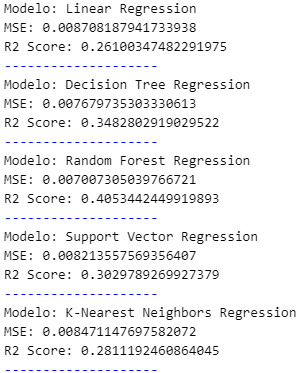

Para complementar lo anterior teniendo en cuenta que el problema a resolver es de regresión múltiple se revisarán XGBoost Regression, Bayesian Regression y Quantile Regression.

In [ ]:
# Librerías para nuevos modelos
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import QuantileRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Recordemos cuales son nuestras variables predictoras (X) y la variable objetivo (y)
X = target_df[[
'Amstel_Utra_prop_volume(l)','Amstel_Utra_prop_age(minutes)',
'Carta_Blanca_prop_volume(l)','Carta_Blanca_prop_age(minutes)',
'Coors_Light_prop_volume(l)','Coors_Light_prop_age(minutes)',
'Miller_prop_volume(l)','Miller_prop_age(minutes)',
'Sol_prop_volume(l)','Sol_prop_age(minutes)',
'Tecate_prop_volume(l)','Tecate_prop_age(minutes)',
'Tecate_Light_prop_volume(l)','Tecate_Light_prop_age(minutes)',
'RIZZOS_prop_volume(l)','RIZZOS_prop_age(minutes)',
'Bohemia_prop_volume(l)','Bohemia_prop_age(minutes)',
'Noche_Buena_prop_volume(l)','Noche_Buena_prop_age(minutes)']]
y = target_df['co2_flow(l)']

Revisaremos outliers

In [ ]:
# Creamos una lista relacionada con la columna de volumen para luego crear una columna sumarizando
volume_columns = [col for col in target_df.columns if 'prop_volume(l)' in col]
target_df['prop_volume(l)'] = target_df[volume_columns].sum(axis=1)

In [ ]:
# Creamos una lista relacionada con la columna de age para luego crear una columna sumarizando
age_columns = [col for col in target_df.columns if 'prop_age(minutes)' in col]
target_df['prop_age(minutes)'] = target_df[age_columns].mean(axis=1)

In [ ]:
# Revisaremos outliers
fig, axs = plt.subplots(2, figsize=(5, 5))
plt1 = sns.boxplot(x=target_df['prop_volume(l)'], ax=axs[0])
plt2 = sns.boxplot(x=target_df['prop_age(minutes)'], ax=axs[1])
plt.tight_layout()

In [ ]:
# Volveremos a revisar la distribución de la variable objetivo
sns.distplot(y);

Se confirma la distribución normal de del flujo de CO2.

In [ ]:
# La relación entre las variables predictoras y la variable objetivo se grafica a continuación
sns.pairplot(target_df, x_vars=['prop_volume(l)', 'prop_age(minutes)'], y_vars='co2_flow(l)', height=4, aspect=1, kind='scatter')
plt.show()

In [ ]:
# Dividimos el conjunto de entrenamiento y prueba
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 100)

In [ ]:
y_train.shape

In [ ]:
y_test.shape

Reforzar el análisis exploratorio que se había hecho en secciones anteriores nos permitirá tener presente el comportamiento de las variables definidas antes de pasar a revisar uno a uno los nuevos modelos a evaluar.

In [ ]:
# Se revisarán varios modelos de regresión para mirar sus métricas de desempeño posteriormente

newmodels = {
    'XGBoost Regression': xgb.XGBRegressor(),
    'Bayesian Regression': BayesianRidge(),
    'Quantile Regression': QuantileRegressor(),
}

In [ ]:
# Se Entrena y evalua cada modelo, se seleccionará el mejor modelo según las métricas MSE y R2

for model_name, model in newmodels.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Modelo: {model_name}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}")
    print("-" * 20)

El mejor resultado se obtiene con XGBoost Regression con R2 Score de 42% y se procederá a buscar mejores parámetros

In [ ]:
# Se vuelve a llamar al modelo XGBoost Regressor complementando parámetros
xgbregmodel = xgb.XGBRegressor(objective ='reg:squarederror',
                               colsample_bytree = 0.3,
                               learning_rate = 0.1,
                               max_depth = 5,
                               alpha = 10,
                               n_estimators = 10)

In [ ]:
# Se entrena al modelo
xgbregmodel.fit(X_train, y_train)

In [ ]:
#Predicting the Test and Train set result
yxgred_pred= xgbregmodel.predict(X_test)
xxgred_pred= xgbregmodel.predict(X_train)

In [ ]:
print("Prediction for test set: {}".format(yxgred_pred))

In [ ]:
# Valor actual vs predicho
xgredmodel_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
xgredmodel_diff

In [89]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
param_grid_gb = {
    'n_estimators': [10, 100, 500, 1000],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [3,4,5,6],
    'min_samples_split': [15,20,50],
    'min_samples_leaf': [3,4,5,12]
}

part_grid_gb = {
    'min_samples_leaf': [3,4,5,12]
}

# Crear un objeto GridSearchCV para Random Forest
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5, scoring='r2',n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

gb_bp = grid_search_gb.best_params_

# Imprimir los mejores parámetros y el mejor puntaje R2 para Random Forest
print("Mejores parámetros para Gradient Boost:", gb_bp)
print("Mejor R2 para Random Gradient Boost:", grid_search_gb.best_score_)

In [ ]:
best_gb = GradientBoostingRegressor(**gb_bp)
best_gb.fit(X_train, y_train)
best_gb.fit(X_train, y_train)
y_pred_gb = best_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"R2 Score para Gradient Boost (con ajuste de parámetros): {r2_gb}")

In [54]:
temp_flow_df = flow_df.copy()
temp_flow_df['hour'] = flow_df['measured_at'].map(lambda x: x[:13])
temp_flow_df['date_hour'] = flow_df['measured_at'].map(lambda x: x[:16])
temp_flow_df.head()

,measured_at,CO2 flow(l),hour,date_hour
0,2022-11-11 19:27:48.947,3065.975586,2022-11-11 19,2022-11-11 19:27
1,2022-11-11 19:28:08.541,3013.935791,2022-11-11 19,2022-11-11 19:28
2,2022-11-11 19:29:09.060,2971.429932,2022-11-11 19,2022-11-11 19:29
3,2022-11-11 19:29:29.410,3016.319336,2022-11-11 19,2022-11-11 19:29
4,2022-09-11 08:55:08.658,2542.399902,2022-09-11 08,2022-09-11 08:55


In [55]:
datehour_sums = temp_flow_df.groupby(['hour'])['CO2 flow(l)'].sum()
datehour_sums.head()

,CO2 flow(l)
hour,
2022-08-08 15,183053.593506
2022-08-08 16,279509.866455
2022-08-08 17,259217.543091
2022-08-08 18,281356.285156
2022-08-08 19,288459.908936


In [56]:
datehour_target_df = pd.DataFrame()
datehour_target_df['datetime(yyyy-mm-dd hh)'] = datehour_sums.index
datehour_target_df['co2_flow(l)'] = datehour_sums.values
datehour_target_df.head()

,datetime(yyyy-mm-dd hh),co2_flow(l)
0,2022-08-08 15,183053.593506
1,2022-08-08 16,279509.866455
2,2022-08-08 17,259217.543091
3,2022-08-08 18,281356.285156
4,2022-08-08 19,288459.908936


In [77]:
def datehours_comparison(df_row, ref_dt):
    dt_format = '%Y-%m-%d %H'
    dt_reference = datetime.datetime.strptime(ref_dt, dt_format)
    dt_start = datetime.datetime.strptime(f"{df_row['start_con_date']} {df_row['start_con_time'][:2]}", dt_format)
    dt_end = datetime.datetime.strptime(f"{df_row['end_con_date']} {df_row['end_con_time'][:2]}", dt_format)
    delta_start = dt_reference - dt_start
    delta_end = dt_end - dt_reference
    seconds_start = delta_start.total_seconds()
    seconds_end = delta_end.total_seconds()

    if seconds_start < 1:
        return 0
    elif seconds_end < 1:
        return 0
    else:
        return seconds_start/86_400

In [ ]:
"""
for brand in registers_df.Brand.unique():
    datehour_target_df[f'{brand.replace(" ","_")}_prop_volume(l)'] = np.zeros((len(datehour_target_df),))
    datehour_target_df[f'{brand.replace(" ","_")}_prop_age(minutes)'] = np.zeros((len(datehour_target_df),))
    dh_brand_df = temp_registers_df[temp_registers_df['Brand'] == brand]
    for reference_dh in datehour_target_df['datetime(yyyy-mm-dd hh)'].values:
        current_dh_df = dh_brand_df.copy()
        current_dh_df['age'] = current_dh_df.apply(
            lambda x: datehours_comparison(x, reference_dh), axis=1)
        if current_dh_df['age'].sum() == 0:
            continue
        current_dh_df['prop_capacity']  = current_dh_df.capacity * current_dh_df.age
        prop_vol, prop_age = current_dh_df[['prop_capacity', 'age']].sum().values
        datehour_target_df.loc[datehour_target_df['datetime(yyyy-mm-dd hh)'] == reference_dh,
                           f'{brand.replace(" ","_")}_prop_volume(l)'] = prop_vol
        datehour_target_df.loc[datehour_target_df['datetime(yyyy-mm-dd hh)'] == reference_dh,
                           f'{brand.replace(" ","_")}_prop_age(minutes)'] = prop_age
"""

In [82]:
datehour_target_df.describe()

,co2_flow(l),Amstel_Utra_prop_volume(l),Amstel_Utra_prop_age(minutes),Carta_Blanca_prop_volume(l),Carta_Blanca_prop_age(minutes),Coors_Light_prop_volume(l),Coors_Light_prop_age(minutes),Miller_prop_volume(l),Miller_prop_age(minutes),Sol_prop_volume(l),Sol_prop_age(minutes),Tecate_prop_volume(l),Tecate_prop_age(minutes),Tecate_Light_prop_volume(l),Tecate_Light_prop_age(minutes),RIZZOS_prop_volume(l),RIZZOS_prop_age(minutes),Bohemia_prop_volume(l),Bohemia_prop_age(minutes),Noche_Buena_prop_volume(l),Noche_Buena_prop_age(minutes)
count,1.783900e+04,17839.000000,17839.000000,1.783900e+04,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,1.783900e+04,17839.000000,1.783900e+04,17839.000000,1.783900e+04,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000
mean,3.629569e+05,2231.286087,0.509604,2.006441e+05,29.500159,1147.568763,0.242561,1850.898079,0.404049,2.064373e+05,30.797060,7.676754e+05,112.906822,3.244461e+05,54.742748,121.455799,0.017861,9.475494,0.004307,58.688127,0.027947
std,1.484359e+05,6234.151748,1.297632,4.634129e+05,68.142562,4837.701488,1.078686,5319.803816,1.151006,4.618230e+05,67.937038,9.358595e+05,137.632290,5.622784e+05,100.149377,1426.567288,0.209789,188.266275,0.085576,870.142530,0.414354
min,-4.965625e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.626837e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.509553e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.906833e+05,28.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.509747e+05,0.000000,0.000000,1.955000e+04,2.833333,0.000000,0.000000,0.000000,0.000000,2.732500e+04,4.250000,1.509427e+06,222.604167,4.522750e+05,57.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.278106e+06,64262.500000,10.625000,1.687533e+06,248.166667,47466.666667,15.583333,43066.666667,11.333333,1.693483e+06,249.041667,2.871300e+06,422.250000,2.323825e+06,405.500000,26350.000000,3.875000,5683.333333,2.583333,19162.500000,9.125000


In [84]:
datehour_target_df.head()

,datetime(yyyy-mm-dd hh),co2_flow(l),Amstel_Utra_prop_volume(l),Amstel_Utra_prop_age(minutes),Carta_Blanca_prop_volume(l),Carta_Blanca_prop_age(minutes),Coors_Light_prop_volume(l),Coors_Light_prop_age(minutes),Miller_prop_volume(l),Miller_prop_age(minutes),Sol_prop_volume(l),Sol_prop_age(minutes),Tecate_prop_volume(l),Tecate_prop_age(minutes),Tecate_Light_prop_volume(l),Tecate_Light_prop_age(minutes),RIZZOS_prop_volume(l),RIZZOS_prop_age(minutes),Bohemia_prop_volume(l),Bohemia_prop_age(minutes),Noche_Buena_prop_volume(l),Noche_Buena_prop_age(minutes)
0,2022-08-08 15,183053.593506,0.0,0.0,861900.000000,126.750000,15070.833333,3.166667,0.0,0.0,866150.000000,127.375000,16150.000000,2.375000,774545.833333,154.166667,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-08-08 16,279509.866455,0.0,0.0,862466.666667,126.833333,15441.666667,3.250000,0.0,0.0,867283.333333,127.541667,16433.333333,2.416667,775716.666667,154.333333,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-08-08 17,259217.543091,0.0,0.0,863033.333333,126.916667,15812.500000,3.333333,0.0,0.0,868416.666667,127.708333,16716.666667,2.458333,776887.500000,154.500000,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-08-08 18,281356.285156,0.0,0.0,863600.000000,127.000000,16183.333333,3.416667,0.0,0.0,869550.000000,127.875000,17000.000000,2.500000,778058.333333,154.666667,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-08-08 19,288459.908936,0.0,0.0,864166.666667,127.083333,16554.166667,3.500000,0.0,0.0,870683.333333,128.041667,17283.333333,2.541667,779229.166667,154.833333,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
hour_path = os.path.join(data_folder, 'hour_target_data.csv')

# datehour_target_df.to_csv(hour_path)

In [ ]:
datehour_target_df = pd.read_csv(hour_path)

In [107]:
x_cols = [
'Amstel_Utra_prop_volume(l)','Amstel_Utra_prop_age(minutes)',
'Carta_Blanca_prop_volume(l)','Carta_Blanca_prop_age(minutes)',
'Coors_Light_prop_volume(l)','Coors_Light_prop_age(minutes)',
'Miller_prop_volume(l)','Miller_prop_age(minutes)',
'Sol_prop_volume(l)','Sol_prop_age(minutes)',
'Tecate_prop_volume(l)','Tecate_prop_age(minutes)',
'Tecate_Light_prop_volume(l)','Tecate_Light_prop_age(minutes)',
'RIZZOS_prop_volume(l)','RIZZOS_prop_age(minutes)',
'Bohemia_prop_volume(l)','Bohemia_prop_age(minutes)',
'Noche_Buena_prop_volume(l)','Noche_Buena_prop_age(minutes)']

In [108]:
X_h = datehour_target_df[x_cols]
y_h = datehour_target_df['co2_flow(l)']

In [93]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [94]:
X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h, y_h, test_size=0.20, random_state=20)

In [102]:
X_h_train.shape

(14271, 20)

In [104]:
X_h_test.shape

(3568, 20)

In [105]:
y_h_train.shape

(14271,)

In [106]:
y_h_test.shape

(3568,)

In [103]:
gb_h = GradientBoostingRegressor(n_estimators=1000, max_depth=3)
gb_h.fit(X_h_train, y_h_train)
gb_h.score(X_h_test, y_h_test)

0.4721578165161594

In [109]:
normalized_dh_df = datehour_target_df.copy()
for col_name in x_cols:
    normalized_dh_df[col_name] = normalized_dh_df[col_name]/normalized_dh_df[col_name].abs().max()

normalized_dh_df.head()

,datetime(yyyy-mm-dd hh),co2_flow(l),Amstel_Utra_prop_volume(l),Amstel_Utra_prop_age(minutes),Carta_Blanca_prop_volume(l),Carta_Blanca_prop_age(minutes),Coors_Light_prop_volume(l),Coors_Light_prop_age(minutes),Miller_prop_volume(l),Miller_prop_age(minutes),Sol_prop_volume(l),Sol_prop_age(minutes),Tecate_prop_volume(l),Tecate_prop_age(minutes),Tecate_Light_prop_volume(l),Tecate_Light_prop_age(minutes),RIZZOS_prop_volume(l),RIZZOS_prop_age(minutes),Bohemia_prop_volume(l),Bohemia_prop_age(minutes),Noche_Buena_prop_volume(l),Noche_Buena_prop_age(minutes)
0,2022-08-08 15,183053.593506,0.0,0.0,0.510745,0.510745,0.317504,0.203209,0.0,0.0,0.511461,0.511461,0.005625,0.005625,0.333306,0.380189,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-08-08 16,279509.866455,0.0,0.0,0.511081,0.511081,0.325316,0.208556,0.0,0.0,0.512130,0.512130,0.005723,0.005723,0.333810,0.380600,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-08-08 17,259217.543091,0.0,0.0,0.511417,0.511417,0.333129,0.213904,0.0,0.0,0.512799,0.512799,0.005822,0.005822,0.334314,0.381011,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-08-08 18,281356.285156,0.0,0.0,0.511753,0.511753,0.340941,0.219251,0.0,0.0,0.513468,0.513468,0.005921,0.005921,0.334818,0.381422,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-08-08 19,288459.908936,0.0,0.0,0.512089,0.512089,0.348754,0.224599,0.0,0.0,0.514138,0.514138,0.006019,0.006019,0.335322,0.381833,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
normalized_dh_df.describe()

,co2_flow(l),Amstel_Utra_prop_volume(l),Amstel_Utra_prop_age(minutes),Carta_Blanca_prop_volume(l),Carta_Blanca_prop_age(minutes),Coors_Light_prop_volume(l),Coors_Light_prop_age(minutes),Miller_prop_volume(l),Miller_prop_age(minutes),Sol_prop_volume(l),Sol_prop_age(minutes),Tecate_prop_volume(l),Tecate_prop_age(minutes),Tecate_Light_prop_volume(l),Tecate_Light_prop_age(minutes),RIZZOS_prop_volume(l),RIZZOS_prop_age(minutes),Bohemia_prop_volume(l),Bohemia_prop_age(minutes),Noche_Buena_prop_volume(l),Noche_Buena_prop_age(minutes)
count,1.783900e+04,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000,17839.000000
mean,3.629569e+05,0.034721,0.047963,0.118898,0.118872,0.024176,0.015565,0.042978,0.035651,0.121901,0.123662,0.267362,0.267393,0.139617,0.135001,0.004609,0.004609,0.001667,0.001667,0.003063,0.003063
std,1.484359e+05,0.097011,0.122130,0.274610,0.274584,0.101918,0.069220,0.123525,0.101559,0.272706,0.272794,0.325936,0.325950,0.241962,0.246978,0.054139,0.054139,0.033126,0.033126,0.045409,0.045409
min,-4.965625e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.626837e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.509553e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066410,0.066410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.509747e+05,0.000000,0.000000,0.011585,0.011417,0.000000,0.000000,0.000000,0.000000,0.016135,0.017065,0.525695,0.527186,0.194625,0.140773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.278106e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
X_h_n = normalized_dh_df[x_cols]
y_h_n = normalized_dh_df['co2_flow(l)']

In [157]:
X_h_n_train, X_h_n_test, y_h_n_train, y_h_n_test = train_test_split(X_h_n, y_h_n, test_size=0.20, random_state=10)

In [119]:
gb_h_n = GradientBoostingRegressor(n_estimators=1000, max_depth=3)
gb_h_n.fit(X_h_n_train, y_h_n_train)
gb_h_n.score(X_h_n_test, y_h_n_test)

0.4581695862357432

In [168]:
from sklearn.svm import SVR

In [ ]:
model = SVR(kernel='linear')



In [99]:
param_grid_gb = {
    'n_estimators': [10, 100, 500, 1000],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [3,4,5,6],
    'min_samples_split': [15,20,50],
    'min_samples_leaf': [3,4,5,12]
}

part_grid_gb = {
    'min_samples_leaf': [3,4,5,12]
}

# Crear un objeto GridSearchCV para Random Forest
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_h_train, y_h_train)

gb_bp = grid_search_gb.best_params_

# Imprimir los mejores parámetros y el mejor puntaje R2 para Random Forest
print("Mejores parámetros para Gradient Boost:", gb_bp)
print("Mejor R2 para Random Gradient Boost:", grid_search_gb.best_score_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


KeyboardInterrupt: 

In [ ]:
best_gb = GradientBoostingRegressor(**gb_bp)
best_gb.fit(X_train, y_train)
best_gb.fit(X_train, y_train)
y_pred_gb = best_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"R2 Score para Gradient Boost (con ajuste de parámetros): {r2_gb}")

In [ ]:
datetime_sums = temp_flow_df.groupby(['date_hour'])['CO2 flow(l)'].sum()
datetime_sums.head()

,CO2 flow(l)
date_hour,
2022-08-08 15:34,9141.914307
2022-08-08 15:35,6884.342529
2022-08-08 15:36,6868.452393
2022-08-08 15:37,6920.094971
2022-08-08 15:38,6833.097168


In [ ]:
datetime_target_df = pd.DataFrame()
datetime_target_df['datetime(yyyy-mm-dd hh:mm)'] = datetime_sums.index
datetime_target_df['co2_flow(l)'] = datetime_sums.values
datetime_target_df.head()

,datetime(yyyy-mm-dd hh:mm),co2_flow(l)
0,2022-08-08 15:34,9141.914307
1,2022-08-08 15:35,6884.342529
2,2022-08-08 15:36,6868.452393
3,2022-08-08 15:37,6920.094971
4,2022-08-08 15:38,6833.097168


In [ ]:
temp_registers_df.head()

,UT,Brand,capacity,start_con_date,end_con_date,start_con_time,end_con_time,initial_age
0,13,Amstel Utra,6800,2022-04-13,2022-04-17,13:00,11:00,895
1,13,Carta Blanca,6800,2022-01-18,2022-01-22,19:00,09:00,1081
2,13,Carta Blanca,6800,2022-03-22,2022-03-26,17:00,02:34,1513
4,13,Carta Blanca,6800,2022-05-28,2022-06-01,07:00,05:36,895
5,13,Carta Blanca,6800,2022-08-21,2022-08-26,18:35,17:36,970


In [ ]:
def datetimes_comparison(df_row, ref_dt):
    dt_format = '%Y-%m-%d %H:%M'
    dt_reference = datetime.datetime.strptime(ref_dt, dt_format)
    dt_start = datetime.datetime.strptime(f"{df_row['end_con_date']} {df_row['end_con_time']}", dt_format)
    dt_end = datetime.datetime.strptime(f"{df_row['start_con_date']} {df_row['start_con_time']}", dt_format)
    delta_start = dt_reference - dt_start
    delta_end = dt_end - dt_reference
    seconds_start = delta_start.total_seconds()
    seconds_end = delta_end.total_seconds()

    if seconds_start < 1:
        return 0
    elif seconds_end < 1:
        return 0
    else:
        return seconds_start/86_400

In [ ]:
og_datetime_target_df = datetime_target_df.copy()
og_datetime_target_df

,datetime(yyyy-mm-dd hh:mm),co2_flow(l)
0,2022-08-08 15:34,9141.914307
1,2022-08-08 15:35,6884.342529
2,2022-08-08 15:36,6868.452393
3,2022-08-08 15:37,6920.094971
4,2022-08-08 15:38,6833.097168
...,...,...
966005,2024-09-27 20:12,6520.064200
966006,2024-09-27 20:13,6572.501300
966007,2024-09-27 20:14,6040.583700
966008,2024-09-27 20:15,4665.304000


In [ ]:
for brand in registers_df.Brand.unique():
    datetime_target_df[f'{brand.replace(" ","_")}_prop_volume(l)'] = np.zeros((len(datetime_target_df),))
    datetime_target_df[f'{brand.replace(" ","_")}_prop_age(minutes)'] = np.zeros((len(datetime_target_df),))
    dt_brand_df = pl.from_pandas(temp_registers_df[temp_registers_df['Brand'] == brand])
    print('Brand')
    for reference_dt in datetime_target_df['datetime(yyyy-mm-dd hh:mm)'].values:
        current_dt_df = dt_brand_df.clone()
        current_dt_df['age'] = current_dt_df.apply(
            lambda x: datetimes_comparison(x, reference_dt), axis=1)
        current_dt_df['prop_capacity']  = current_dt_df.capacity * temp_brand_df.age
        prop_vol, prop_age = temp_brand_df[['prop_capacity', 'age']].sum().values
        datetime_target_df.loc[datetime_target_df['datetime(yyyy-mm-dd hh:mm)'] == reference_date,
                           f'{brand.replace(" ","_")}_prop_volume(l)'] = prop_vol
        datetime_target_df.loc[datetime_target_df['datetime(yyyy-mm-dd hh:mm)'] == reference_date,
                           f'{brand.replace(" ","_")}_prop_age(minutes)'] = prop_age
        print('.')

Brand


AttributeError: 'DataFrame' object has no attribute 'apply'

In [ ]:
for brand in registers_df.Brand.unique():
    datetime_target_df[f'{brand.replace(" ","_")}_prop_volume(l)'] = np.zeros((len(datetime_target_df),))
    datetime_target_df[f'{brand.replace(" ","_")}_prop_age(minutes)'] = np.zeros((len(datetime_target_df),))
    temp_2_df = temp_registers_df.copy()
    for reference_date in datetime_target_df['date(yyyy-mm-dd)'].values:
        temp_brand_df = temp_2_df[temp_2_df['Brand'] == brand]
        temp_brand_df['proportion'] = temp_brand_df.apply(
            lambda x: calc_date_proportion(x, reference_date), axis=1)
        temp_brand_df['prop_capacity'] = temp_brand_df.capacity * temp_brand_df.proportion
        temp_brand_df['prop_age'] = 720 * temp_brand_df['proportion'] + temp_brand_df['initial_age']
        temp_brand_df.loc[temp_brand_df.proportion == 0.0, 'prop_age'] = 0.0
        prop_vol, prop_age = temp_brand_df[['prop_capacity', 'prop_age']].sum().values
        datetime_target_df.loc[datetime_target_df['date(yyyy-mm-dd)'] == reference_date,
                           f'{brand.replace(" ","_")}_prop_volume(l)'] = prop_vol
        datetime_target_df.loc[datetime_target_df['date(yyyy-mm-dd)'] == reference_date,
                           f'{brand.replace(" ","_")}_prop_age(minutes)'] = prop_age